In [1]:
import numpy as np 
import math
import peakutils
import numpy.fft as fft
import matplotlib as mpl 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
from matplotlib import cm  
from scipy.integrate import odeint 
import scipy.signal as signal 
from scipy.stats import loguniform


import pickle 
import random as rand  
from numpy import random
#from dFlipFlop import DFlipFlop
#from acdc import ACDC  
#from repressilator import Repressilator
from sklearn import decomposition 
from deap import creator, base, tools, algorithms 
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans  
import os.path 

#from sympy import latex 


In [51]:
'''
The deterministic model of biological oscillator
''' 
class Oscillator: 
	
	def __init__(self, parameter_values, params, initial_conditions, dt = 0.001, mode = 0): 
		self.nParams = len(params)   
		self.params = params #model parameters
		self.parameter_values = parameter_values #allowed parameter ranges  
		self.y0 = initial_conditions 	
		self.dt = dt
		self.T = 200 
		self.N = int(self.T/self.dt) 
		self.ts = np.linspace(0, self.T, self.N) 
		self.amp = 300 #[nM] 		
		self.per = self.T/8 	
		self.sample_rate 		= 0.0033333333 #Hz 
		self.samples_per_hour 	= (1/self.dt)		
		self.jump 				= int(self.samples_per_hour/(self.sample_rate*3600))  	 	
		self.ideal = self.amp*(np.sin(math.pi*(self.ts)/self.per - math.pi/2) + 1) 
		#number of samples for FFT		
		self.nS = self.N/self.jump 
		self.dF = self.sample_rate/self.nS  
		self.idealF = self.getFrequencies(self.ideal) 		 	
		thresholdOne = -(self.nS/2)*100 #10nM -+ from ideal signal harmonics       
		thresholdTwo = 0.5  
		self.minAmp = 1
		self.maxAmp = 6000 
		self.mode = mode    			
		self.modes = [self.eval]       
		self.threshold = thresholdOne  
		self.omega = 1 #nm^-1 
		if self.mode == 1:
			self.threshold = thresholdTwo
	
	#gets summed difference of arrayData
	@staticmethod 	
	def getDif(indexes, arrayData):	
		arrLen = len(indexes)
		sum = 0
		for i, ind in enumerate(indexes):
			if i == arrLen - 1:
				break
			sum += arrayData[ind] - arrayData[indexes[i + 1]]
			
		#add last peak - same as substracting it from zero 
		sum += arrayData[indexes[-1:]]  
		return sum   
		
	#gets standard deviation 
	@staticmethod 
	def getSTD(indexes, arrayData, window):
		numPeaks = len(indexes)
		arrLen = len(arrayData)
		sum = 0
		for ind in indexes:
			minInd = max(0, ind - window)
			maxInd = min(arrLen, ind + window)
			sum += np.std(arrayData[minInd:maxInd])  
			
		sum = sum/numPeaks 	
		return sum	 
	
	def getFrequencies(self, y):
		#fft sample rate: 1 sample per 5 minutes
		y = y[0::self.jump]  
		res = abs(fft.rfft(y))
		#normalize the amplitudes 
		res = res/math.ceil(self.nS/2) 
		return res

	def costOne(self, Y): 
		p1 = Y[:,1]   
		fftData = self.getFrequencies(p1)     
		
		diff = fftData - self.idealF         
		cost = -np.dot(diff, diff) 		
		return cost,	
		
	def costTwo(self, Y, getAmplitude = False): 
		p1 = Y[:,5]  
		fftData = self.getFrequencies(p1)      
		fftData = np.array(fftData) 
		#find peaks using very low threshold and minimum distance
		indexes = peakutils.indexes(fftData, thres=0.02/max(fftData), min_dist=1)  
		#in case of no oscillations return 0 
		if len(indexes) == 0:     
			return 0,  
		#if amplitude is greater than 400nM
		amp = np.max(fftData[indexes])
		if amp > self.maxAmp: 
			return 0, 
		fitSamples = fftData[indexes]  			
		std = self.getSTD(indexes, fftData, 1)  
		diff = self.getDif(indexes, fftData)  
		cost = std + diff
		#print(cost)   
		if getAmplitude:
			return cost, amp
		return cost, 
		
	def isViableFitness(self, fit):
		return fit >= self.threshold
		
	def isViable(self, point): 
		fitness = self.eval(point, getAmplitude=True)  
		if self.mode == 0:
			return self.isViableFitness(fitness[0]) 
			
		fit = fitness[0] 
		amp = 0
		if fit > 0:
			amp = fitness[1] 
		return self.isViableFitness(fit) and amp >= self.minAmp and amp <= self.maxAmp   
		
	#evaluates a candidate  
	def eval(self, candidate, getAmplitude = False): 
		Y = np.array(self.simulate(candidate)) 
		if self.mode == 0:
			return self.costOne(Y)  
		else:
			return self.costTwo(Y, getAmplitude)      
	
	#simulates a candidate
	def simulate(self, candidate): 
		return odeint(self.oscillatorModelOde, candidate[15:], self.ts, args=(candidate,))   		

	def plotModel(self, subject, mode="ode", show=True):     		
		if mode == "ode":
			t = np.linspace(0, self.T, self.N)
			solutions = self.simulate(subject) 			
		#else:
			#ssa simulation
			#ts,Y = self.represilatorStochastic(subject)
			
		fig = plt.figure(figsize=(8,4),dpi=200)

		plt.plot(t,solutions[:,0], color="b", label = 'L')
		plt.plot(t,solutions[:,1], color="g", label = 'Lp')
		plt.plot(t,solutions[:,2], color="gold", label = 'K')
		plt.plot(t,solutions[:,3], color="r", label = 'P')
		plt.plot(t,solutions[:,4], color="cyan", label = 'LK')
		plt.plot(t,solutions[:,5], color="black", label = 'A')
		plt.plot(t,solutions[:,6], color="indigo", label = 'LpA')
		plt.plot(t,solutions[:,7], color="yellow", label = 'LpAK')
		plt.plot(t,solutions[:,8], color="magenta", label = 'LpAP')
		plt.plot(t,solutions[:,9], color="deeppink", label = 'LpAPLp')
		plt.plot(t,solutions[:,10], color="peru", label = 'LpAKL')

		plt.plot(t,solutions[:,11], color="purple", label = 'PLp')


		plt.xlabel('Time (s)')
		plt.ylabel('Concentration (uM)')
		##plt.ylim(top=110, bottom = -10)
		plt.legend(loc = 'upper right', prop={'size': 6})

		plt.show()
			 				

	def getTotalVolume(self):
		vol = 1.0
		for param in self.params:		
			vol = vol*(self.parameter_values[param]["max"] - self.parameter_values[param]["min"])
		return vol 

	def oscillatorModelOde(self, Y, t, can): 

		V = can[12]
		VA = can[13]
		#A = V/VA
		sigma = can[14]
		#y1 = VA/(2*sigma)
		
		
		ka1 = can[0]
		kb1 = can[1]
		kcat1 = can[2]

		ka2 = can[3]
		kb2 = can[4]

		ka3 = can[5]
		kb3 = can[6]

		ka4 = can[7]
		kb4 = can[8]

		ka7 = can[9]
		kb7 = can[10]
		kcat7 = can[11]

		ka5 = can[9]
		kb5 = can[10]
		kcat5 = can[11]

	

		ka6 = can[0]
		kb6 = can[1]
		kcat6 = can[2]

		
		#initial conditions
		L = Y.item(0)   # make sure in uM
		Lp = Y.item(1) 
		K = Y.item(2)
		P = Y.item(3)
		LK = Y.item(4) 
		A = Y.item(5)
		LpA = Y.item(6) 
		LpAK = Y.item(7) 
		LpAP = Y.item(8) 
		LpAPLp = Y.item(9) 
		LpAKL = Y.item(10) 
		LpP = Y.item(11) 
	
		dL = (kb1*LK) - (ka1*L*K) + (kcat5*LpAPLp) + (kb6*LpAKL) - ((VA/(2*sigma))*ka6*LpAK*L) + (kcat7*LpP)
		dLp = (kcat1*LK) + (kb2*LpA) - (ka2*Lp*A) + (kb5*LpAPLp) - ((VA/(2*sigma))*ka5*Lp*LpAP) + (kcat6*LpAKL) - (ka7*Lp*P) + (kb7*LpP)
		dK = (kb1*LK) - (ka1*L*K) + (kcat1*LK) + (kb3*LpAK) - (ka3*LpA*K)
		dP = (kb4*LpAP) - (ka4*LpA*P) - (ka7*Lp*P) + (kb7*LpP) + (kcat7*LpP)
		dLK = (ka1*L*K) - (kb1*LK) - (kcat1*LK)
		dA = (kb2*LpA) - (ka2*Lp*A)
		dLpA = (ka2*Lp*A) - (kb2*LpA) + (kb3*LpAK) - (ka3*LpA*K) + (kb4*LpAP) - (ka4*LpA*P)
		dLpAK = (ka3*LpA*K) - (kb3*LpAK) + (kb6*LpAKL) - ((VA/(2*sigma))*ka6*LpAK*L) + (kcat6*LpAKL)
		dLpAP = (ka4*LpA*P) - (kb4*LpAP) + (kb5*LpAPLp) - ((VA/(2*sigma))*ka5*LpAP*Lp) + (kcat5*LpAPLp)
		dLpAPLp = ((VA/(2*sigma))*ka5*LpAP*Lp) - (kb5*LpAPLp) - (kcat5*LpAPLp)
		dLpAKL = ((VA/(2*sigma))*ka6*LpAK*L) - (kb6*LpAKL) - (kcat6*LpAKL)
		dLpP = (ka7*Lp*P) - (kb7*LpP) - (kcat7*LpP)

		return([dL, dLp, dK, dP, dLK, dA, dLpA, dLpAK, dLpAP, dLpAPLp, dLpAKL, dLpP])	
	
	def getPerAmp(self, subject, mode="ode", indx=0): 
		if mode == "ode":
			ts = np.linspace(0, self.T, self.N) 
			Y = self.simulate(subject)    				
		#else:
			#ts,Y = self.represilatorStochastic(subject) 
		ts = np.array(ts) 
		Y = np.array(Y) 
		sig = Y[:, indx]
		indx_max, properties = signal.find_peaks(sig, prominence = (np.max(sig) - np.min(sig))/4, distance = len(ts)/100)      
		indx_min, properties = signal.find_peaks(sig*-1, prominence = (np.max(sig) - np.min(sig))/4, distance = len(ts)/100)     

		amps = [] 
		pers = []   
		for i in range(min(len(indx_max), len(indx_min))):
			amps.append((sig[indx_max[i]] - sig[indx_min[i]])/2) 			
			if i + 1 < len(indx_max):
				pers.append(ts[indx_max[i + 1]] - ts[indx_max[i]])
			if i + 1 < len(indx_min):
				pers.append(ts[indx_min[i + 1]] - ts[indx_min[i]])
		
		if len(amps) > 0 and len(pers) > 0:
			amps = np.array(amps)   	
			pers = np.array(pers)  
			
			#print(amps)
			amp = np.mean(amps)	
			#print(pers) 
			per = np.mean(pers) 
		else:
			amp = 0
			per = 0  
		
		print("amp" + str(amp)) 
		print("per" + str(per))   	
		
		return per, amp 
	

In [3]:
'''
Regions consist of cloud of points and principal component that govern the direction of exploration  
''' 
class Region: 
	def __init__(self, points, model, label, depth=1):    
		self.points = np.array(points)  
		self.model = model  
		self.pca = PCA(n_components=self.model.nParams)
		self.components = None
		self.prevComponents = None 
		self.cluster = False
		self.terminated = False  
		self.iter = 0      
		self.maxIter = 10            
		self.threshold = 0.001    
		self.label = label
		self.maxVarScale = 4
		self.minVarScale = 2   
		self.varScaleDt = (self.maxVarScale - self.minVarScale)/(float(self.maxIter))    		     		
		self.varScale = self.maxVarScale         
		self.depth = depth     
		
	def updateVariance(self): 
		self.varScale = self.varScale - self.varScaleDt

	def updateIter(self):
		self.iter = self.iter + 1
		self.updateVariance()          	
		
	def fitPCA(self): 
		self.prevComponents = self.components 
		self.pca.fit(self.points)
		self.components = self.pca.components_
	
	def transform(self, points):  
		return self.pca.transform(points)  
		
	def inverse_transform(self, points):
		return self.pca.inverse_transform(points)   
		
	def converged(self):
		if self.components is None or self.prevComponents is None: 
			return False		
		return np.linalg.norm(self.components - self.prevComponents) < self.threshold   
		
	def explored(self):    
		return self.terminated or self.iter > self.maxIter or self.converged()   

In [82]:
'''
The main class
'''
class Solver:
	def __init__(self, model, populationSize=5000, NGEN = 10, nsamples = 1e5):                                                      
		self.model = model            
		self.populationSize = populationSize         
		self.NGEN = NGEN  
		self.nsamples = int(nsamples) 	
		self.indpb = 0.75     	
		
		#GA operators
		creator.create("FitnessMax", base.Fitness, weights=(1.0,)) 
		creator.create("Candidate", list, fitness=creator.FitnessMax)  		
		self.toolbox = base.Toolbox()	 
		self.toolbox.register("candidate", self.generateCandidate) 
		self.toolbox.register("population", tools.initRepeat, list, self.toolbox.candidate)  
		self.toolbox.register("mate", tools.cxTwoPoint)
		self.toolbox.register("mutate", self.mutateCandidate, indpb=self.indpb, mult=0.5)      
		self.toolbox.register("select", tools.selTournament, tournsize=int(self.populationSize/10))     		
	
	#### functions for printing NERDSS parameters ####
	def waterbox(self,V,VA):
		V = V * 1e9 #convert um3 to nm3
		VA = VA * 1000 #convert um to nm 

		A = V/VA #units of nm2
		x = np.sqrt(A)
		y = np.sqrt(A)
		z = V/A 

		dimensions = ['x: ' + str(x), 'y: ' + str(y), 'z: ' + str(z)]
		#ztest = z/10
		#xtest = np.sqrt(V/ztest)
		#ytest = np.sqrt(V/ztest)

		#test = (ztest*xtest*ytest)/(xtest*ytest)

		return dimensions

	def copynumber(self, conc, volume, um = True):
		if um == True:
			volume = volume/1e15 #converts liters to um^3
			conc = conc/1e6 #converts umol to mol
			
			moles = conc * volume #volume must be passed in um^-3
			copies = moles * 6.023e23
			
			return copies
		elif um == False:
			volume = volume/1e15
			moles = conc / volume
			rate = moles / 6.023e23

			return rate

	def rate_converter(self, rate, ka = True):
		#convert ka in (uM*s)^-1 to nm^3/us
		if ka == True:
			new_rate = rate/1e6 #seconds to microseconds
			new_rate = new_rate * 1e24 #convert liters to nm^3
			new_rate = new_rate/(6.022*1e17) #convert micromoles to copies 
			return new_rate
		else: #else kb or kcat in s^-1
			new_rate = rate / 1e6 #convert per second to per microsecond
			return new_rate 




	#estimate initial values with GA
	def findNominalValues(self):    	 	
		nominalVals = []   
		
		for evalMode in self.model.modes: 
			nominalValsMode = []
			self.toolbox.register("evaluate", evalMode)   
			#initialize new random population
			self.popu = self.toolbox.population(self.populationSize)  	 
			
			for gen in range(self.NGEN):  
				print(gen)
				#generate offspprings with crossover and mutations
				offspring = algorithms.varAnd(self.popu, self.toolbox, cxpb=0.5, mutpb=0.75)  
				#evaluate individuals
				fits = self.toolbox.map(self.toolbox.evaluate, offspring) 
				for fit, ind in zip(fits, offspring): 
					if self.model.isViable(ind) and ind not in nominalValsMode:  
						nominalValsMode.append(ind)      
					ind.fitness.values = fit     
				#roulete wheel selection
				self.popu = self.toolbox.select(offspring, k=len(self.popu)) 
				
				rando = np.random.randint(0, len(self.popu))
				rdm_ind = self.popu[rando]
				rdm_ind_label = {}

				for parameter, value in zip(parameter_values.keys(), rdm_ind):
					rdm_ind_label[parameter] = value


				print(rdm_ind_label)

				kadic = {'ka1':rdm_ind[0],'ka2':rdm_ind[3],'ka3':rdm_ind[5],'ka4':rdm_ind[7],'ka5':rdm_ind[9]}
				kbdic = {'kb1':rdm_ind[1],'kb2':rdm_ind[4],'kb3':rdm_ind[6],'kb4':rdm_ind[8],'kb5':rdm_ind[10]}
				kcatdic = {'kcat1':rdm_ind[2],'kcat5':rdm_ind[11]}
				KDdic = {'Km1':(rdm_ind[1]+rdm_ind[2])/rdm_ind[0],'Kd2':rdm_ind[4]/rdm_ind[3],'Kd3':rdm_ind[6]/rdm_ind[5],'Kd4':rdm_ind[8]/rdm_ind[7],'Km5':(rdm_ind[10]+rdm_ind[11])/rdm_ind[9]}
				comparison_list = [kadic,kbdic,kcatdic,KDdic]

				for h in comparison_list:
					sorted_dict = {}
					sorted_keys = sorted(h, key=h.get)  # [1, 3, 2]

					string = str()
					for i in range(len(sorted_keys)):
						string += sorted_keys[i] + " > "
					print(string)
				
				#calculate waterbox dimensions for NERDSS
				waterbox = self.waterbox(rdm_ind[12], rdm_ind[13])

				#convert parameters for NERDSS
				NERDSSparamlist = []
				for param in rdm_ind_label.items():
					if 'ka' in param[0]:
						converted_rate = self.rate_converter(param[1])
						NERDSSparamlist.append(param[0] + ': ' + str(converted_rate) + ' nm^3/us')
					elif 'kb' in param[0] or 'kcat' in param[0]:
						converted_rate = self.rate_converter(param[1], ka = False)
						NERDSSparamlist.append(param[0] + ': ' + str(converted_rate) + ' us^-1')
					elif 'V' in param[0]:
						pass
					elif 'sigma' in param[0]:
						sig = param[1] * 1e3
						NERDSSparamlist.append(param[0] + ': ' + str(sig) + ' nm')
					else:
						copynumber = self.copynumber(param[1],rdm_ind_label['V'])
						NERDSSparamlist.append(param[0] + ': ' + str(copynumber) + ' copies')

				print('NERDSS parameters')
				print(NERDSSparamlist)

				print('Waterbox dimensions')
				print(waterbox)




				print("Number of viable points: " + str(len(nominalValsMode))) 

				print(self.model.isViable(rdm_ind))
				print(self.model.eval(rdm_ind))
				
				self.model.plotModel(rdm_ind)



				     
			
			print("Number of viable points: " + str(len(nominalValsMode))) 
			nominalVals.extend(nominalValsMode)     
		return nominalVals        


		
	#creates an array of random candidates  
	def generateCandidate(self): 
		candidate = []
		for ind in range(self.model.nParams): 
			#try:
				#candidate.append(loguniform.rvs(self.model.parameter_values[self.model.params[ind]]["min"], self.model.parameter_values[self.model.params[ind]]["max"]))
			#except ValueError:
			candidate.append(random.uniform(self.model.parameter_values[self.model.params[ind]]["min"], self.model.parameter_values[self.model.params[ind]]["max"]))
		return creator.Candidate(candidate) 	
		
	def checkOutAllBounds(self, candidate):
		for idx, val in enumerate(candidate):
			if self.checkOutOfBounds(candidate, idx): 
				return True  
		return False      
				
	def checkOutOfBounds(self, candidate, idx): 
		#if out of bounds return True 
		if candidate[idx] < self.model.parameter_values[self.model.params[idx]]["min"] or candidate[idx] > self.model.parameter_values[self.model.params[idx]]["max"]: 
			return True
		return False    		
	
	#returns a tuple of mutated candidate	
	def mutateCandidate(self, candidate, indpb, mult): 	
		for idx, val in enumerate(candidate):	
			rnd = random.uniform(0, 1)
			if rnd >= indpb:
				rnd2 = random.uniform(1 - mult, 1 + mult)   
				candidate[idx] = val*rnd2	
				if candidate[idx] < self.model.parameter_values[self.model.params[idx]]["min"]: 
					candidate[idx] = self.model.parameter_values[self.model.params[idx]]["min"]  
				if candidate[idx] > self.model.parameter_values[self.model.params[idx]]["max"]:  
					candidate[idx] = self.model.parameter_values[self.model.params[idx]]["max"]    					
		return candidate,     
	
	def getViablePoints(self, points):
		viable = list() 
		i = 0
		for point in points:  
			i += 1
			if i % 1000 == 0:
				print(i)     
			
			#check if point is viable 
			if self.model.isViable(point): 
				viable.append(point)   		
		return viable          
	
	# gap statistic method
	# returns the optimal number of clusters 	
	def gapStatistic(self, region, number_ref = 10, max_clusters = 2, plot = False):        
		#sample size is equal to the number of samples in gaussian sampling  
		sample_size = self.nsamples    
		subjects = np.array(region.points)                 
		gaps = []
		deviations = []   
		references = [] 
		clusters_range = range(1, max_clusters + 1) 
		
		transformed = region.transform(subjects) 
		#get min and max parameter values in pca space 
		minP = np.min(transformed, axis=0)  
		maxP = np.max(transformed, axis=0)   
		
		for gap_clusters in clusters_range:
			print(gap_clusters) 
			reference_inertia = []	
			for index in range(number_ref): 

				#OBB ... orientated bounding box 
				#random sampling within the PCA bounding box			
				reference = minP + random.rand(sample_size, self.model.nParams)*(maxP - minP)
				reference = region.inverse_transform(reference) 
				
				kmeanModel = KMeans(gap_clusters) 
				kmeanModel.fit(reference) 
				reference_inertia.append(kmeanModel.inertia_)    
			
			kmeanModel = KMeans(gap_clusters)      
			kmeanModel.fit(subjects)     
			log_ref_inertia = np.log(reference_inertia)	 
			#calculate gap
			gap = np.mean(log_ref_inertia) - np.log(kmeanModel.inertia_)  
			sk = math.sqrt(1 + 1.0/number_ref)*np.std(log_ref_inertia)  
			gaps.append(gap)    
			deviations.append(sk)        			
			
		# Plot the gaps   		
		if plot:
			plt.clf() 
			ax = plt.gca() 
			ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))	 
			ax.xaxis.set_major_locator(ticker.MultipleLocator(2))	
			lines = plt.errorbar(clusters_range, gaps, ecolor='dodgerblue', yerr=deviations, fmt='-', color='dodgerblue') 
			plt.setp(lines[0], linewidth=1.5)  
			plt.ylabel('Gaps')
			plt.show()  
			
		#return optimal number of clusters
		for k in range(0, max_clusters - 1): 
			if gaps[k] >= gaps[k + 1] - deviations[k + 1]: 
				print("Optimal number of clusters: " + str(k + 1)) 
				return k + 1     
		print("Optimal number of clusters: " + str(max_clusters))    	
		return max_clusters   

	
	#returns the viable volume for 
	def getViableVolume(self, viableRegions, sample_size = int(1e4)):
		volume = 0 

		for region in viableRegions:		
			regPoints = region.points
			region.fitPCA() 						 						
			transformed = region.transform(regPoints) 
		  		
			minP = np.min(transformed, axis=0)   
			maxP = np.max(transformed, axis=0)   
		
			dP = maxP - minP
			volB = np.prod(dP)			

			mcRef = minP + random.rand(sample_size, self.model.nParams)*dP  
			mcRef = region.inverse_transform(mcRef)	 		
			
			viaPoints = self.getViablePoints(mcRef) 
			count = np.ma.size(viaPoints, axis=0) 
			
			#volume for region  
			ratio = count/sample_size   
			volume = volume + ratio*volB  			
	
		print("Bounding box volume " + str(volB)) 
		print("Volume " + str(volume))   
		print("Total volume " + str(self.model.getTotalVolume()))   		
		print("Volume ratio:" + str(volume/self.model.getTotalVolume())) 
		return volume 

	def setBoxColors(self, bp, nRegions, ax, colors = ["#0E74C8", "#15A357", "r", "k"]):
		colorLen = len(colors) 

		for i in range(nRegions): 
			col = colors[i % colorLen] 		 
			plt.setp(bp['boxes'][i], color=col, linewidth=1.5)    
			plt.setp(bp['caps'][2*i], color=col, linewidth=1.5)  
			plt.setp(bp['caps'][2*i + 1], color=col, linewidth=1.5) 
			plt.setp(bp['whiskers'][2*i], color=col, linewidth=1.5)  
			plt.setp(bp['whiskers'][2*i + 1], color=col, linewidth=1.5)   
			plt.setp(bp['fliers'][i], color=col) 
			plt.setp(bp['medians'][i], color=col, linewidth=1.5)   
		
	def plotParameterVariances(self, viableSets, names=None, units=None):      
		#go through all parameters  
		params = self.model.params    
		figure = plt.figure()     
		nRows = math.ceil(len(params)/3)    
		for pcount, param in enumerate(params):    
			ax1 = plt.subplot(nRows, 3, pcount+1)  
			#if names == None:
			#	ax1.set_title(str(param) + str(pcount))    
			#else:
			#	ax1.set_title(names[pcount])  
			if units != None:
				plt.ylabel(names[pcount] + " " + units[pcount])  
			allRegions = [] 	
			#go through all regions 
			numSets = len(viableSets) 
			allNames = []
			allBoxes = []
			for count, reg in enumerate(viableSets): 
				points = np.array(reg.points)    
				data = points[:,pcount]   
				allRegions.append(data)   
				allNames.append("Region " + str(count + 1))   				
			bp = ax1.boxplot(allRegions, positions=list(range(1, numSets + 1)), widths = 0.4) 
			self.setBoxColors(bp, numSets, ax1) 		
			allBoxes = bp['boxes'] 
			
		#draw legend 
		figure.legend(allBoxes, allNames, 'lower right')
		plt.show()     
		
	#Main method  
	def run(self, filename, maxDepth=0):    
		#filename is a file to which viable sets will be serialized    

		#estimate the inital viable set 
		viablePoints = self.findNominalValues()         		                 		
		
		if not viablePoints: 
			print("No viable points found!")  
			return 
		
		
		
		#dump viable points to file  
		pickle.dump(viablePoints, open(filename + "ViableSet_IterGA.p", "wb+"))   
		
		reg = Region(viablePoints, self.model, "0")   
		reg.fitPCA() 
		
		fpca = PCA(n_components=2)  		 		
		fpca.fit(reg.points)
				
		viableSets = list() 
		viableSets.append(reg)  		  		 
		converged = False 		
		iter = 0 
		
		while not converged: 
			converged = True 			 		 	 					  	 
			iter += 1 
			print("Iteration: " + str(iter))  	
			for set in viableSets:   				
				set.updateIter() 
				#if set not already explored  
				if not set.explored():
					setSize = len(set.points) 
					print("Label: " + set.label)   
					print("Iter: " + str(set.iter))  
					print("Variance scaling factor: " + str(set.varScale))    								
					converged = False   					
					      
					#sample with 0 mean and scaled variance of prinicpal components       
					candidateSet = random.multivariate_normal([0]*self.model.nParams, np.diag(set.pca.explained_variance_)*set.varScale, self.nsamples)				
					candidateSet = set.inverse_transform(candidateSet)      
								
					#check if parameter values are not out of range  		
					inBounds = list() 
					for cand in candidateSet: 				
						if not self.checkOutAllBounds(cand): 
							inBounds.append(cand)  
					inBounds = np.array(inBounds)   		
					candidateSet = inBounds   
					
					X = fpca.transform(set.points) 
					Y = fpca.transform(candidateSet) 	 				
					fig = plt.figure(iter)  
					plt.clf()          
					plt.scatter(Y[:, 0], Y[:, 1], c="red", alpha=0.1, edgecolor='k', rasterized=True, label = "Candidate")  
					plt.scatter(X[:, 0], X[:, 1], c="cornflowerblue", alpha=0.8, edgecolor='k', rasterized=True, label = "Viable")  				
					
					plt.xlabel('PC 1')      
					plt.ylabel('PC 2')  
					plt.title("Iteration"+str(set.iter))  
					plt.legend()
					plt.savefig(filename + "Set" + set.label + "Iter" + str(set.iter) + ".pdf")        	 
					#identify viable points  
					viablePoints = np.array(self.getViablePoints(candidateSet)) 
					
					#if viable set is smaller than number of parameters do not accept it
					print("Number of viable points: " + str(len(viablePoints)))   
					
					if len(viablePoints) <= setSize/10:   						 
						#cluster if not enough points obtained with sampling    
						print("Clustering, insufficient number of points")   
						set.terminated = True      
						set.cluster = True           
					else:
						pickle.dump(candidateSet, open(filename + "_Region" + str(set.label) + "CandidateSet_Iter" + str(set.iter) +  ".p", "wb+"))     
						pickle.dump(viablePoints, open(filename + "_Region" + str(set.label) + "ViableSet_Iter" + str(set.iter) + ".p", "wb+"))  						
						set.points = viablePoints           
						set.fitPCA()     	 			
				#if set not already terminated, terminate it and cluster   
				elif not set.terminated:    
					set.terminated = True       
					set.cluster = True         					
						
			#clustering, check for new clusters        	            
			newViableSets = list()   
			for set in viableSets: 
				if set.cluster and (maxDepth == 0 or set.depth < maxDepth):   
					set.cluster = False    
					setLabel = set.label    
					setDepth = set.depth      
					#determine the optimal number of clusters
					print("Clustering set" + set.label)      
					k = self.gapStatistic(set)    
					if k > 1:     
						#cluster and divide sets based on clustering 
						#update the list of sets 
						converged = False     
						labels = KMeans(n_clusters = k).fit_predict(set.points)         
						for i in range(k): 
							ind = np.where(labels == i)[0]  
							points = set.points[ind]
							reg = Region(points, self.model, setLabel + str(i), depth=setDepth+1)         
							reg.fitPCA()      
							#append new region to new set  
							newViableSets.append(reg)       						 			
			#end of clustering					 
			viableSets.extend(newViableSets)     
		#end of while loop  

## Test values 

In [17]:
parameter_values = {  "ka1": {"min": 0, "max": 1000},  
            "kb1": {"min": 0, "max": 100},             				        
            "kcat1": {"min": 0, "max": 100},         
            "ka2": {"min": 0, "max": 100},         
            "kb2": {"min": 0, "max": 1000}, 
            "ka3": {"min": 0, "max":100}, 
            "kb3": {"min": 0, "max":500},
            "ka4": {"min": 0, "max":100},
            "kb4": {"min": 0, "max": 100},  
            "ka7": {"min": 0, "max": 5000}, 
            "kb7": {"min": 0, "max": 100}, 
            "kcat7": {"min": 0, "max": 200},
            "L": {"min": 0, "max": 500},  
            "Lp": {"min": 0, "max": 0}, 
            "K": {"min": 0, "max": 50},
            "P": {"min": 0, "max": 50},
            "LK": {"min": 0, "max": 0}, 
            "A": {"min": 0, "max": 50}, 
            "LpA": {"min": 0, "max": 0},
            "LpAK": {"min": 0, "max": 0}, 
            "LpAP": {"min": 0, "max": 0}, 	
            "LpAPLp": {"min": 0, "max": 0},
            "LpAKL": {"min": 0, "max": 0},
            "LpP": {"min": 0, "max": 0},
            }   	

filename =  os.path.join(".", "SIMPLE2_oscillatorCostTwo")  
print(filename)   
model = Oscillator(parameter_values, np.array(["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka7","kb7","kcat7","L","Lp","K","P","LK","A","LpA","LpAK","LpAP","LpAPLp","LpAKL","LpP"]), np.array(["L","Lp","K","P",0,"A",0,0,0,0,0,0]), mode=1)  
solver = Solver(model)         
solver.run(filename) 

./SIMPLE2_oscillatorCostTwo
0


IndexError: index 9 is out of bounds for axis 0 with size 9

./SIMPLE2_oscillatorCostTwo


/Users/jonathanfischer/miniforge3/envs/m1/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/jonathanfischer/miniforge3/envs/m1/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Candidate' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


0
[90636.81997809692, 46.406543711306604, 73.87901013152877, 835121.7232996401, 149.39250275770434, 177665.83367128088, 275.6478350799195, 2201.4917092826886, 50.76480350712347, 833717.217599875, 100, 55.407804320151776, 1.9082901374034407, 777646.1706295329, 0.0, 51412.56661802134, 22183.17888374943, 0.0, 119467.56399174048, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


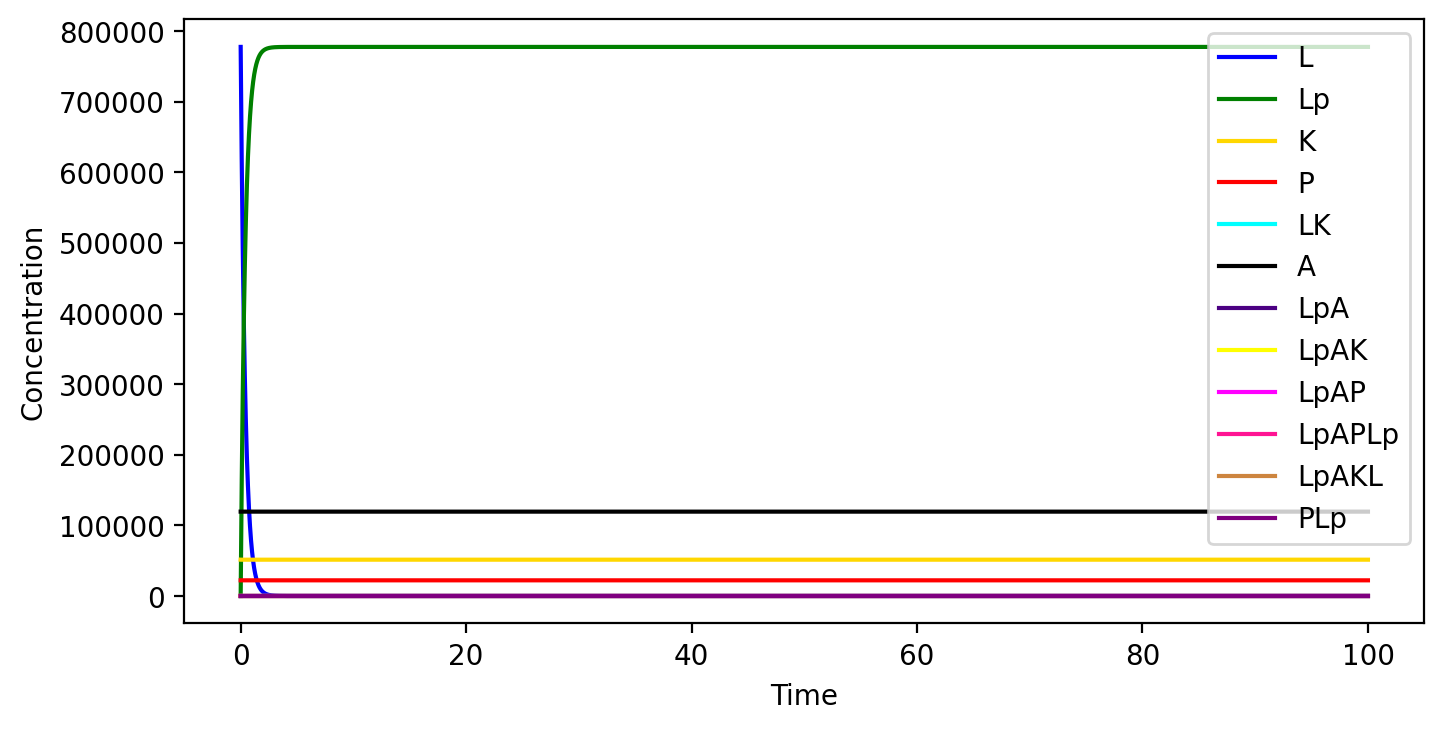

1
[943174.8179955045, 87.4716168324877, 68.7149715099166, 477849.8002765554, 330.55508561125527, 118409.1387333862, 500, 434675.16095928464, 13.709581900677502, 1000000.0, 77.6504025540302, 0.4635191669648542, 0.7676635066520101, 526096.6996218405, 0.0, 97712.32643522338, 19012.34106244239, 0.0, 33482.04253172539, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


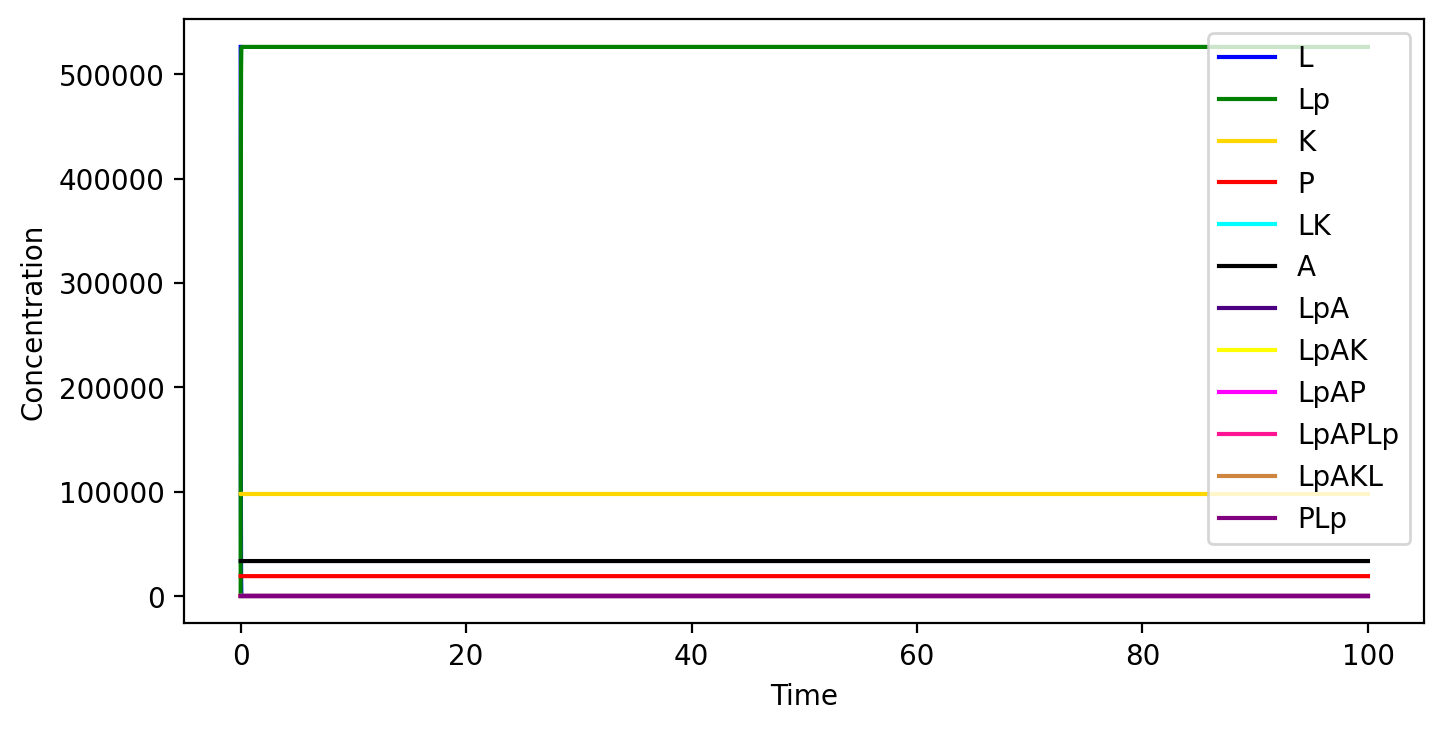

2
[1000000.0, 23.929302694312593, 67.55906824514285, 256659.0260453018, 603.7281052306539, 1000000.0, 0.38188507313480224, 315326.6899224455, 74.11496426212, 288692.26602018124, 60.945896872343496, 37.58068746106018, 0.881737849238518, 771311.680517379, 0.0, 87944.14387011871, 66242.81556640103, 0.0, 275012.1562371156, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


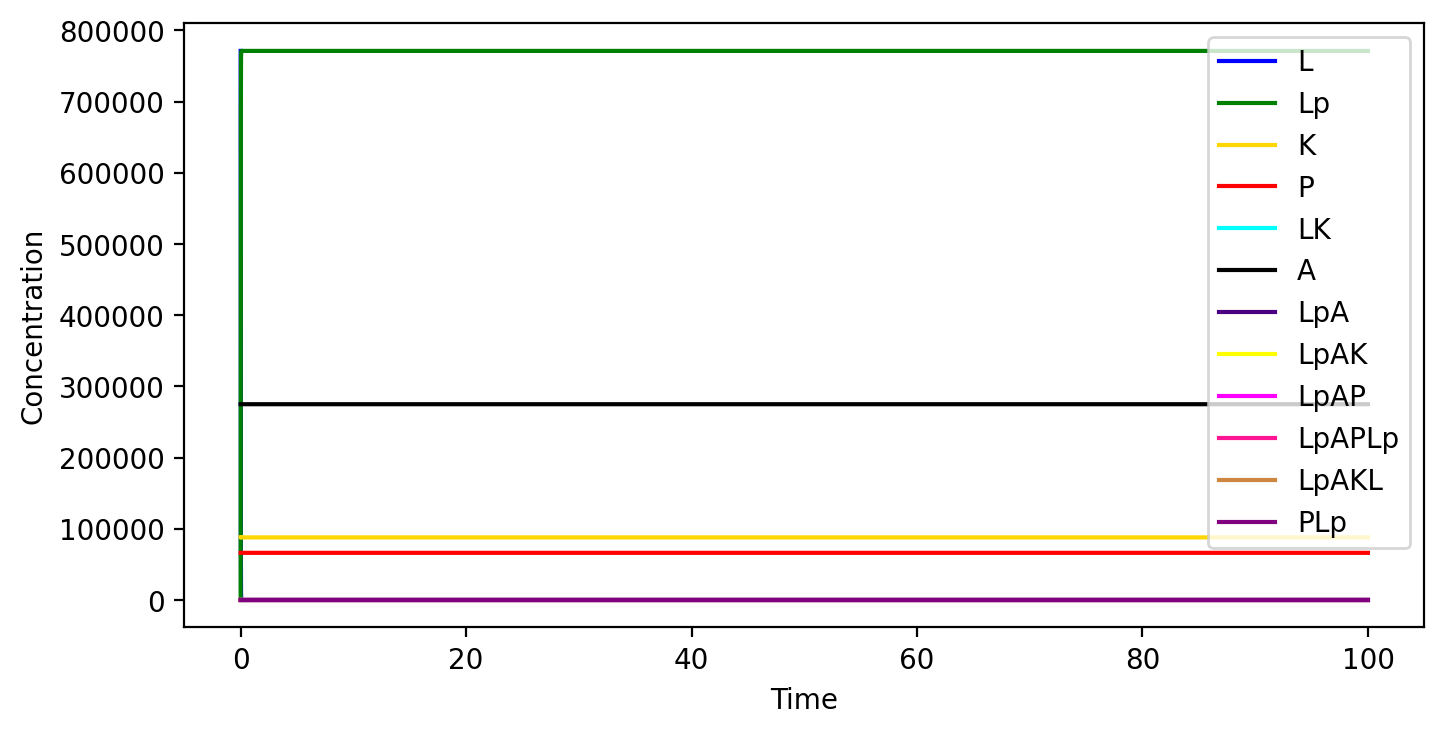

3


/Users/jonathanfischer/miniforge3/envs/m1/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[1000000.0, 23.929302694312593, 67.55906824514285, 256659.0260453018, 603.7281052306539, 1000000.0, 0.38188507313480224, 315326.6899224455, 74.11496426212, 288692.26602018124, 60.945896872343496, 37.58068746106018, 0.881737849238518, 771311.680517379, 0.0, 87944.14387011871, 66242.81556640103, 0.0, 275012.1562371156, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


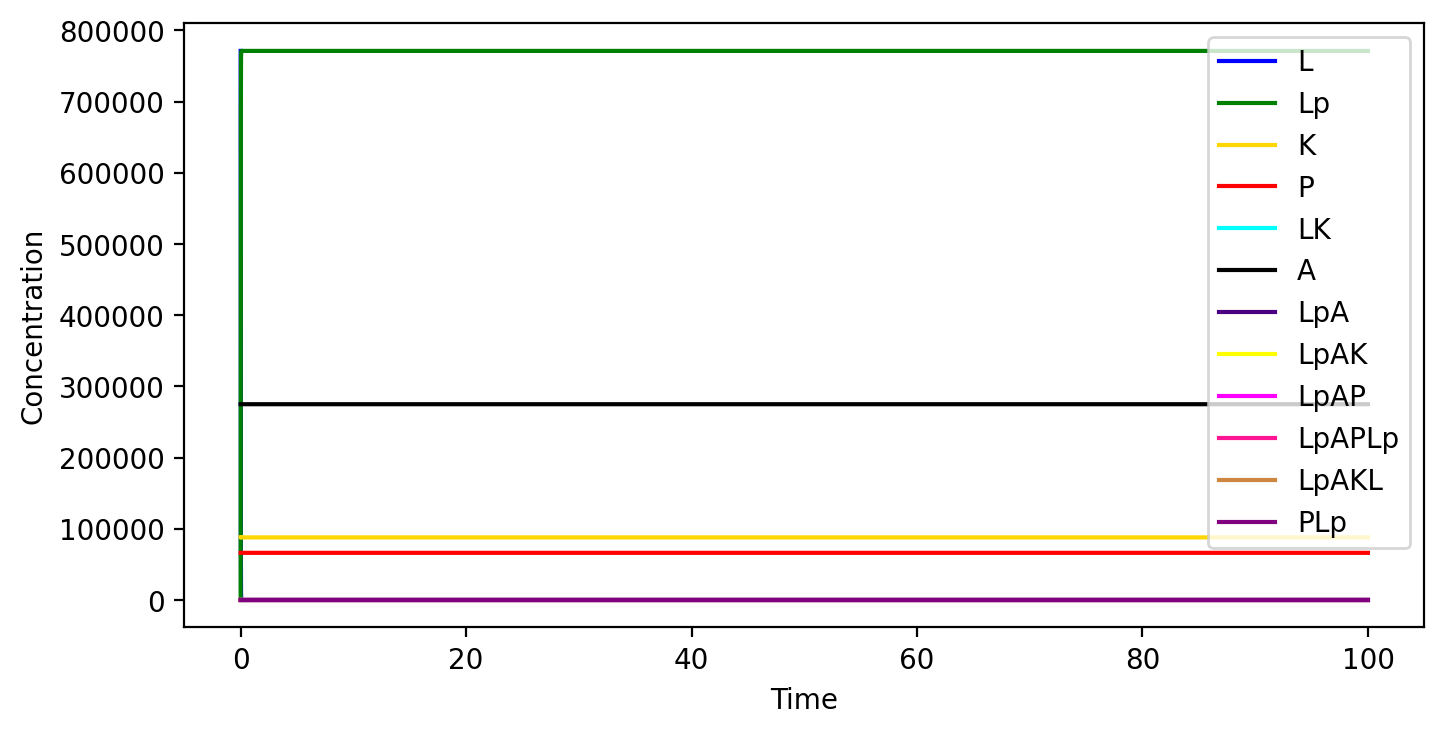

4
[1000000.0, 23.929302694312593, 67.55906824514285, 256659.0260453018, 603.7281052306539, 1000000.0, 0.38188507313480224, 315326.6899224455, 74.11496426212, 288692.26602018124, 60.945896872343496, 37.58068746106018, 0.881737849238518, 771311.680517379, 0.0, 87944.14387011871, 66242.81556640103, 0.0, 275012.1562371156, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


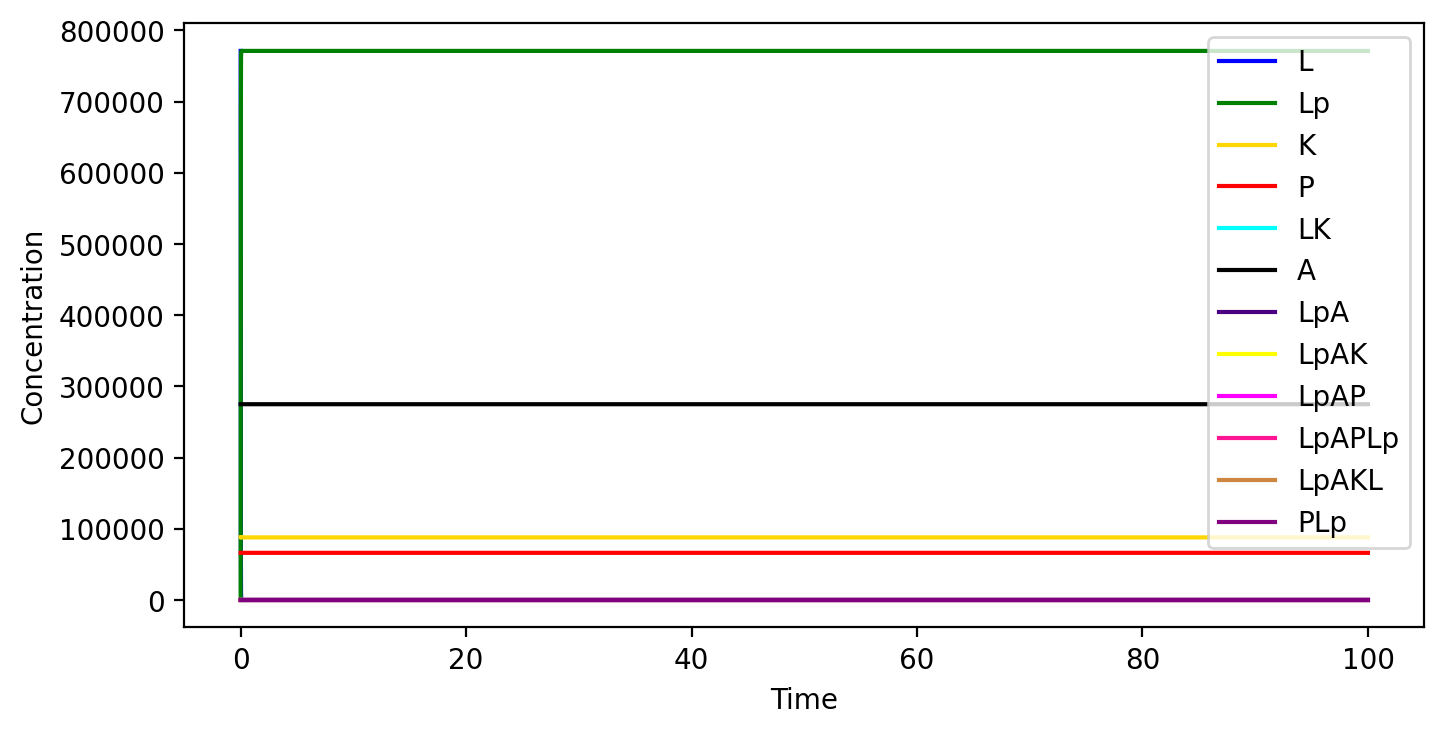

5
[1000000.0, 33.44493729660333, 67.55906824514285, 256659.0260453018, 603.7281052306539, 1000000.0, 0.38188507313480224, 315326.6899224455, 74.11496426212, 288692.26602018124, 60.945896872343496, 37.58068746106018, 0.881737849238518, 771311.680517379, 0.0, 87944.14387011871, 58726.236825107786, 0.0, 300000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


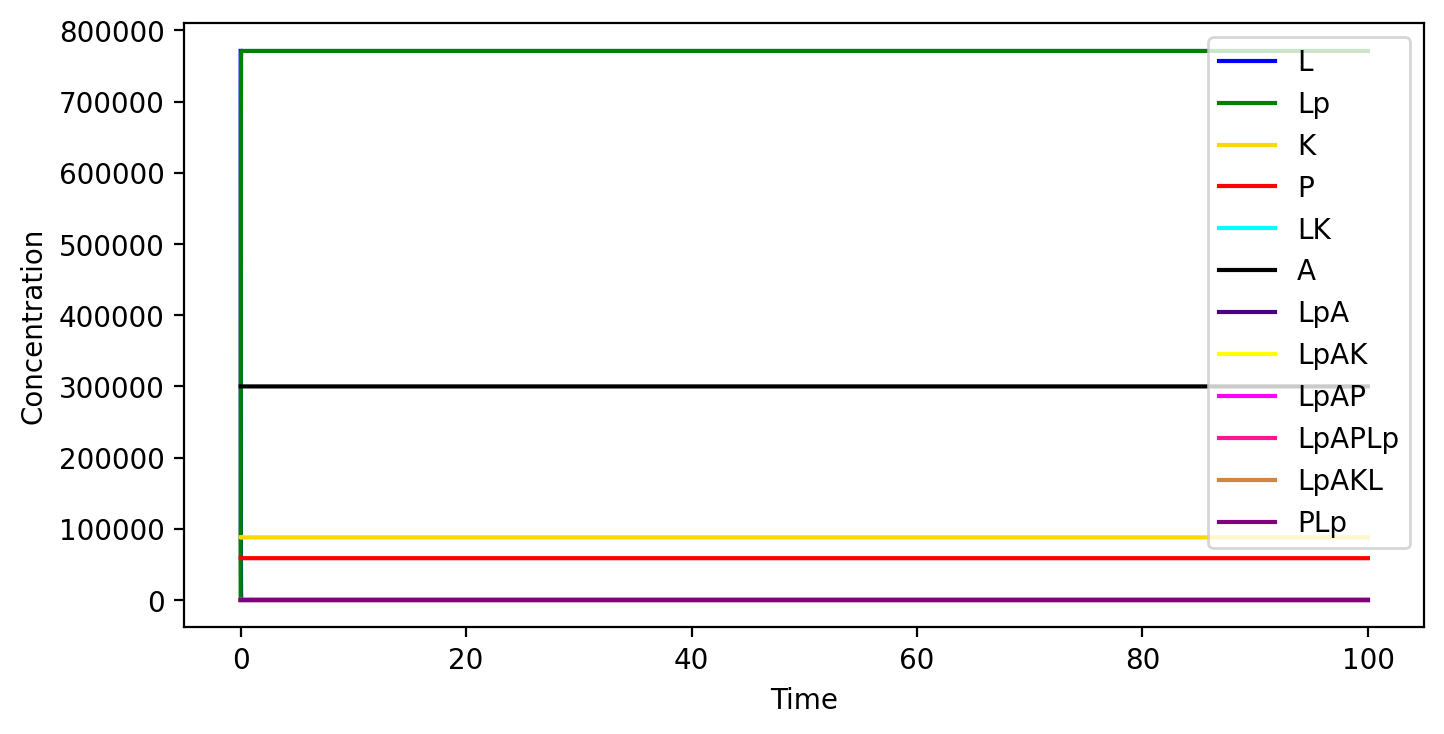

6
[1000000.0, 33.44493729660333, 67.55906824514285, 256659.0260453018, 603.7281052306539, 1000000.0, 0.38188507313480224, 315326.6899224455, 74.11496426212, 288692.26602018124, 60.945896872343496, 37.58068746106018, 0.881737849238518, 771311.680517379, 0.0, 87944.14387011871, 58726.236825107786, 0.0, 300000.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


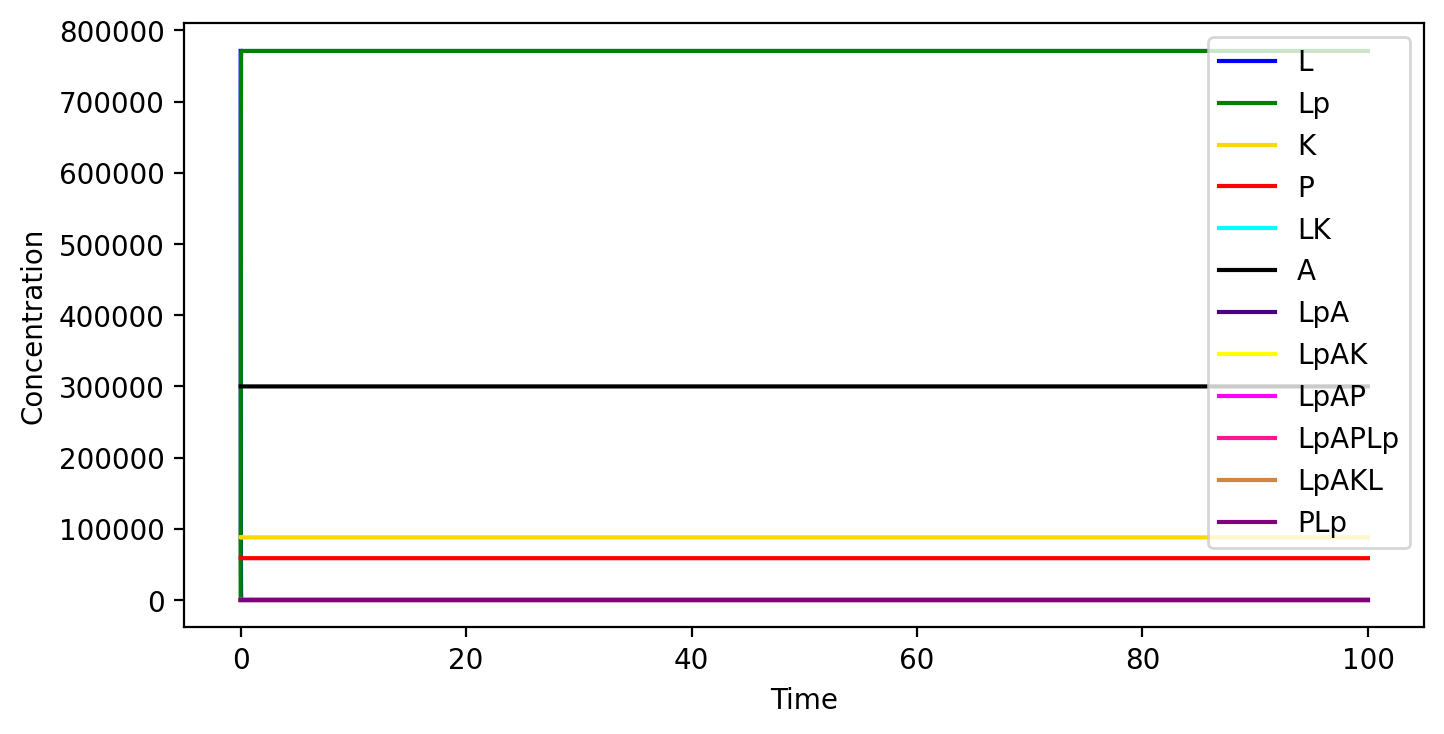

7
[790312.0986846188, 23.929302694312593, 67.55906824514285, 145903.19948369547, 603.7281052306539, 1000000.0, 0.38188507313480224, 315326.6899224455, 66.93513435861671, 288692.26602018124, 26.287548495882618, 37.58068746106018, 0.881737849238518, 771311.680517379, 0.0, 87944.14387011871, 53660.24148896504, 0.0, 275012.1562371156, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


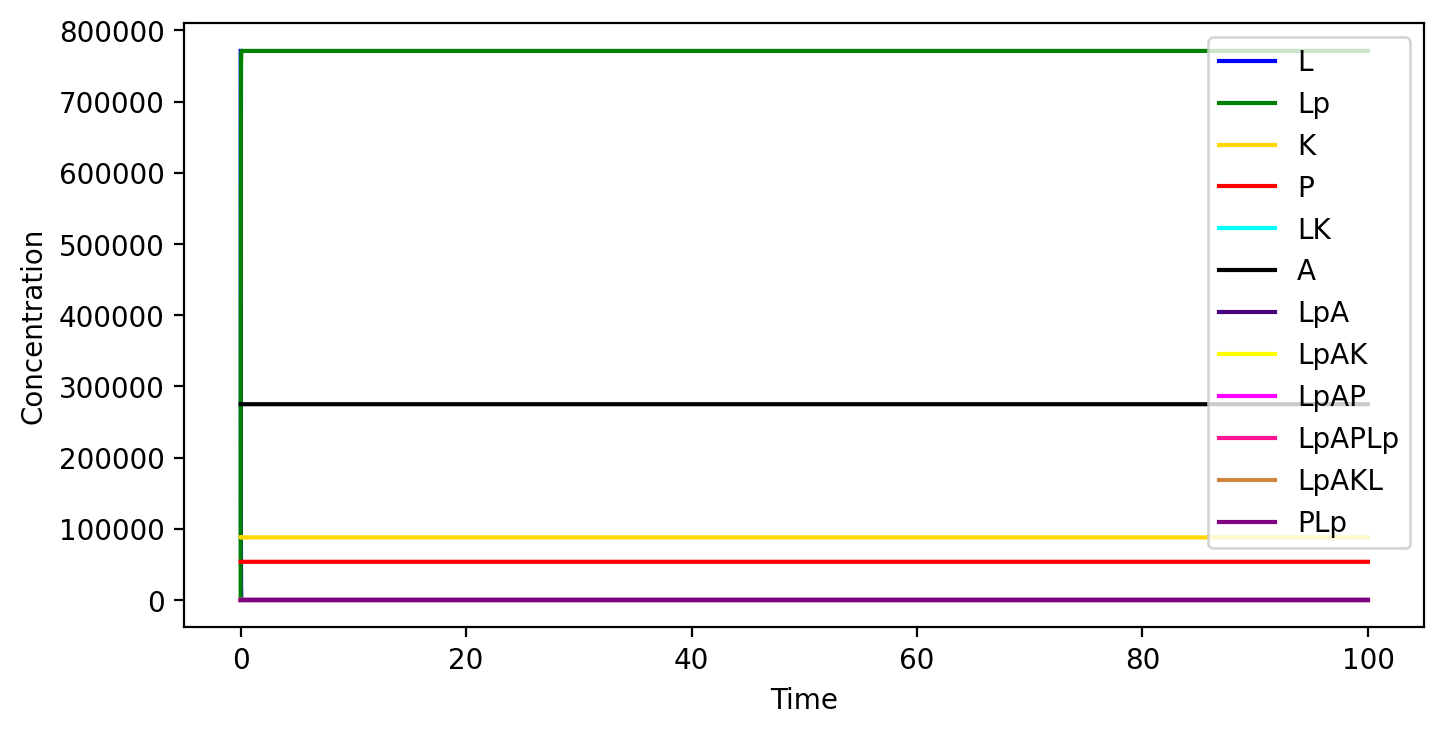

8
[790312.0986846188, 23.929302694312593, 67.55906824514285, 145903.19948369547, 603.7281052306539, 1000000.0, 0.38188507313480224, 315326.6899224455, 66.93513435861671, 288692.26602018124, 26.287548495882618, 37.58068746106018, 0.881737849238518, 771311.680517379, 0.0, 87944.14387011871, 53660.24148896504, 0.0, 275012.1562371156, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


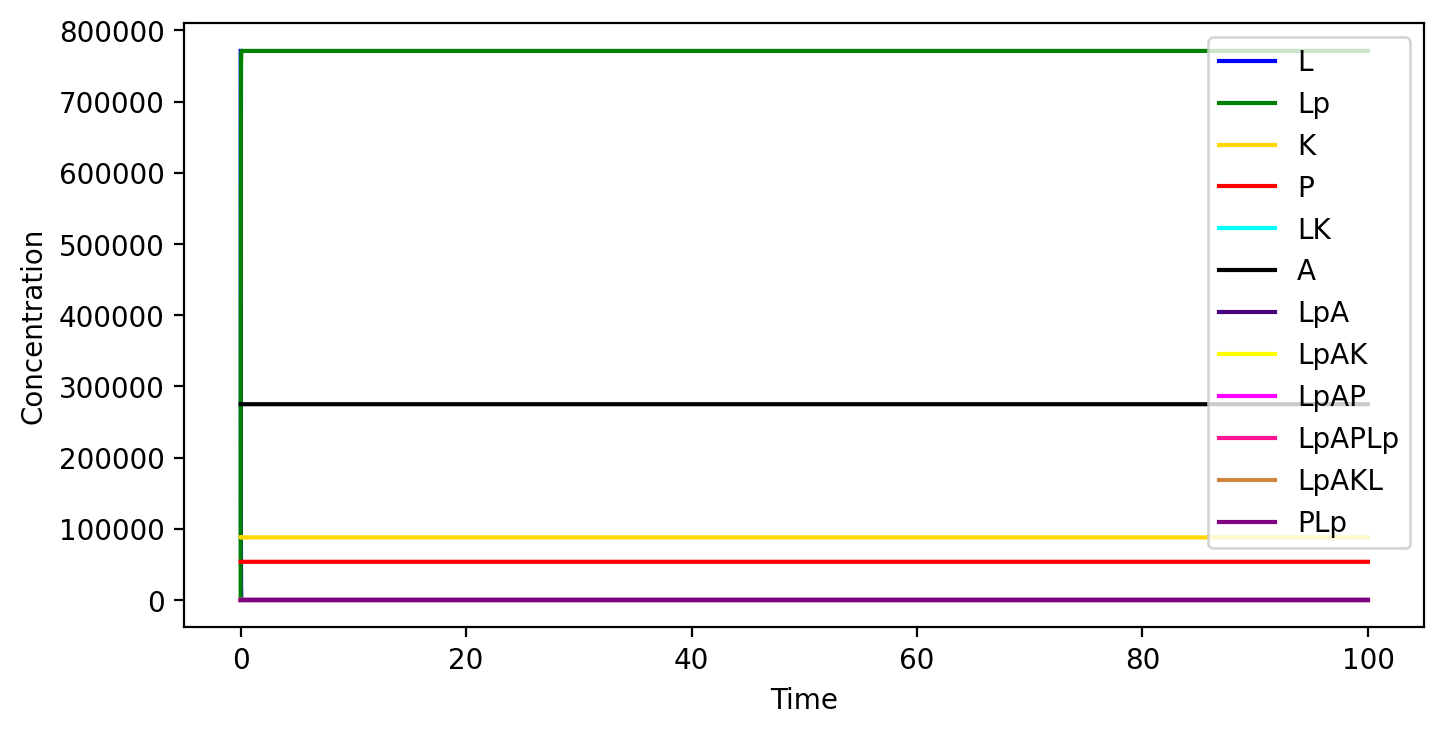

9


KeyboardInterrupt: 

In [10]:
parameter_values = {  "ka1": {"min": 1000, "max": 1e6},  
            "kb1": {"min": 0, "max": 100},             				        
            "kcat1": {"min": 0, "max": 100},         
            "ka2": {"min": 1000, "max": 1e6},         
            "kb2": {"min": 0, "max": 1000}, 
            "ka3": {"min": 1e3, "max":1e6}, 
            "kb3": {"min": 0, "max":500},
            "ka4": {"min": 1e3, "max":1e6},
            "kb4": {"min": 0, "max": 100},  
            "ka5": {"min": 1e3, "max": 1e6}, 
            "kb5": {"min": 0, "max": 100}, 
            "kcat5": {"min": 0, "max": 500},
            "VA": {"min": 0.5, "max": 2},
            "L": {"min": 1e4, "max": 1e6},  
            "Lp": {"min": 0, "max": 0}, 
            "K": {"min": 10000, "max": 100000},
            "P": {"min": 10000, "max": 100000},
            "LK": {"min": 0, "max": 0}, 
            "A": {"min": 1e3, "max": 3e5}, 
            "LpA": {"min": 0, "max": 0},
            "LpAK": {"min": 0, "max": 0}, 
            "LpAP": {"min": 0, "max": 0}, 	
            "LpAPLp": {"min": 0, "max": 0},
            "LpAKL": {"min": 0, "max": 0},
            "LpP": {"min": 0, "max": 0},
            }   	

filename =  os.path.join(".", "SIMPLE2_oscillatorCostTwo")  
print(filename)   
model = Oscillator(parameter_values, np.array(["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka5","kb5","kcat5","VA","L","Lp","K","P","LK","A","LpA","LpAK","LpAP","LpAPLp","LpAKL","LpP"]), np.array(["L","Lp","K","P",0,"A",0,0,0,0,0,0]), mode=1)  
solver = Solver(model)         
solver.run(filename) 

## Good cell

In [18]:
parameter_values = {  "ka1": {"min": 1000/1e6, "max": 1e6/1e6},  
            "kb1": {"min": 0, "max": 100},             				        
            "kcat1": {"min": 0, "max": 500},         
            "ka2": {"min": 1000/1e6, "max": 1e6/1e6},         
            "kb2": {"min": 0, "max": 1000}, 
            "ka3": {"min": 1e3/1e6, "max":1e8/1e6}, 
            "kb3": {"min": 0, "max":500},
            "ka4": {"min": 1e3/1e6, "max":1e6/1e6},
            "kb4": {"min": 0, "max": 100},  
            "ka7": {"min": 1e3/1e6, "max": 1e6/1e6}, 
            "kb7": {"min": 0, "max": 1000}, 
            "kcat7": {"min": 0, "max": 200},
            "V": {"min": 2600, "max": 2600},
            "VA": {"min": 0.5, "max": 2},
            "sigma": {"min": 0.001, "max": 0.001},
            "L": {"min": 1, "max": 1e2},  
            "Lp": {"min": 0, "max": 0}, 
            "K": {"min": 0.01, "max": 0.1},
            "P": {"min": 0.01, "max": 0.1},
            "LK": {"min": 0, "max": 0}, 
            "A": {"min": .1, "max": 10}, 
            "LpA": {"min": 0, "max": 0},
            "LpAK": {"min": 0, "max": 0}, 
            "LpAP": {"min": 0, "max": 0}, 	
            "LpAPLp": {"min": 0, "max": 0},
            "LpAKL": {"min": 0, "max": 0},
            "LpP": {"min": 0, "max": 0},
            }   	

filename =  os.path.join(".", "SIMPLE2_oscillatorCostTwo")  
print(filename)   
model = Oscillator(parameter_values, np.array(["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka7","kb7","kcat7","V","VA","sigma","L","Lp","K","P","LK","A","LpA","LpAK","LpAP","LpAPLp","LpAKL","LpP"]), np.array(["L","Lp","K","P",0,"A",0,0,0,0,0,0]), mode=1)  
solver = Solver(model)         
solver.run(filename) 

./SIMPLE2_oscillatorCostTwo
0


TypeError: can't multiply sequence by non-int of type 'float'

## Test cell

./SIMPLE2_oscillatorCostTwo


/Users/jonathanfischer/miniforge3/envs/m1/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/jonathanfischer/miniforge3/envs/m1/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Candidate' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


0
{'ka1': 0.1666357030796144, 'kb1': 44.736550650930866, 'kcat1': 18.294557640993695, 'ka2': 0.7675317180459815, 'kb2': 225.9742612086676, 'ka3': 59.47205270320178, 'kb3': 112.36558596773972, 'ka4': 0.916866253610568, 'kb4': 100, 'ka7': 0.09583293328772897, 'kb7': 116.93449356099974, 'kcat7': 200, 'V': 0.0885290001079171, 'VA': 0.9207856298298334, 'sigma': 0.00438401852839761, 'L': 82.23956487482302, 'Lp': 0.07817844898863771, 'K': 0.08167314180332419, 'P': 0.06490710670093953, 'LK': 0.07376509004951681, 'A': 6.067690891643166, 'LpA': 0.03437120005385883, 'LpAK': 0.09984895881435325, 'LpAP': 0.02542725652239798, 'LpAPLp': 0.06637283384880738, 'LpAKL': 0.023974239199931864, 'LpP': 0.08571652402766569}
ka5 > ka1 > ka2 > ka4 > ka3 > 
kb1 > kb4 > kb3 > kb5 > kb2 > 
kcat1 > kcat5 > 
Kd3 > Kd4 > Kd2 > Km1 > Km5 > 
NERDSS parameters
['ka1: 0.276711562735992 nm^3/us', 'kb1: 4.4736550650930865e-05 us^-1', 'kcat1: 1.8294557640993696e-05 us^-1', 'ka2: 1.2745461940318525 nm^3/us', 'kb2: 0.00022597

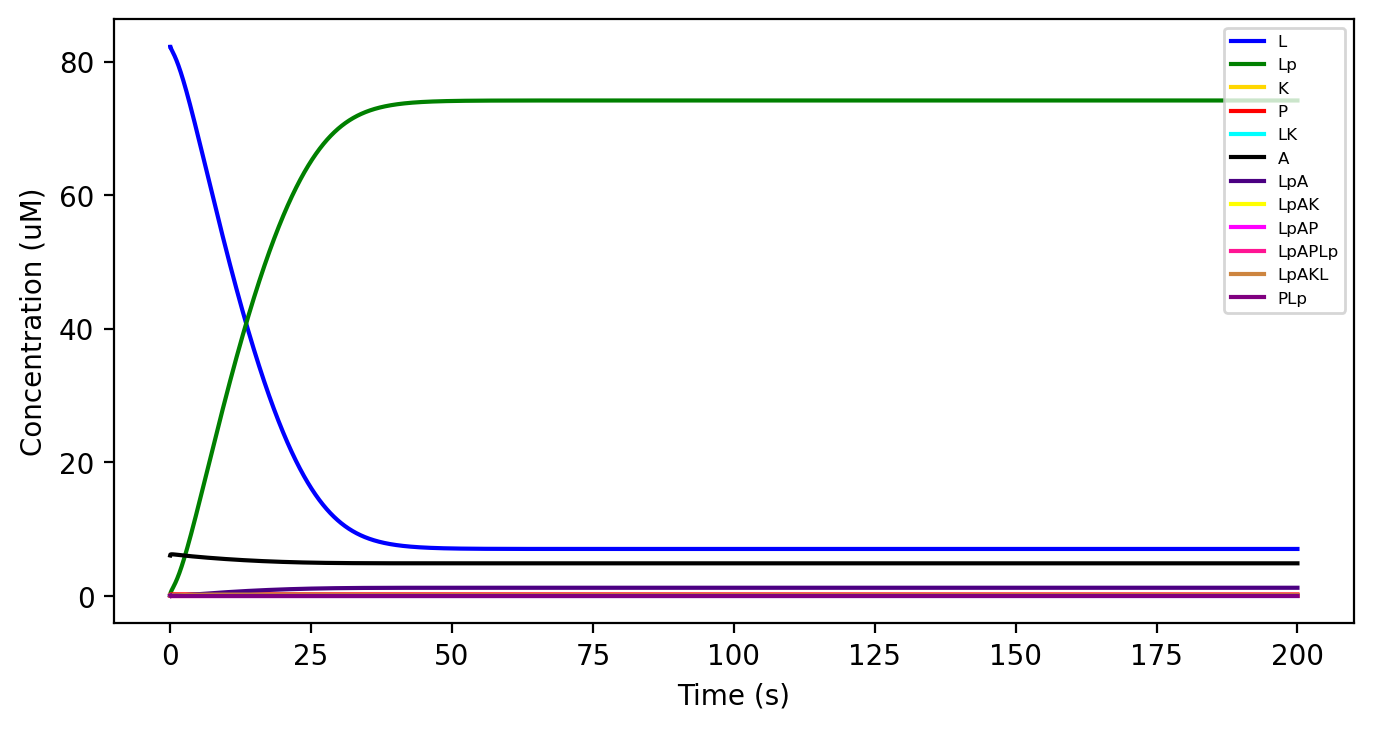

1
{'ka1': 0.15799215653392806, 'kb1': 28.351295265038917, 'kcat1': 306.4036888729987, 'ka2': 0.6323269362397238, 'kb2': 336.91850462140206, 'ka3': 24.71366186997172, 'kb3': 237.82820366555555, 'ka4': 0.022944015876142584, 'kb4': 1, 'ka7': 0.628310050441584, 'kb7': 105.85213670638129, 'kcat7': 88.77325912667814, 'V': 0.09876895387802286, 'VA': 1.0963225126615272, 'sigma': 0.003643605046236881, 'L': 99.36249257706113, 'Lp': 0.07312121436773249, 'K': 0.04929162552454164, 'P': 0.09220505828617995, 'LK': 0.03372711921698293, 'A': 7.107659171541579, 'LpA': 0.08446123333610368, 'LpAK': 0.0814010398110575, 'LpAP': 0.028006425841041786, 'LpAPLp': 0.0489928421951681, 'LpAKL': 0.04863329540439429, 'LpP': 0.063895018251949}
ka4 > ka1 > ka5 > ka2 > ka3 > 
kb4 > kb1 > kb5 > kb3 > kb2 > 
kcat5 > kcat1 > 
Kd3 > Kd4 > Km5 > Kd2 > Km1 > 
NERDSS parameters
['ka1: 0.2623582805279443 nm^3/us', 'kb1: 2.8351295265038917e-05 us^-1', 'kcat1: 0.0003064036888729987 us^-1', 'ka2: 1.0500281239450744 nm^3/us', 'kb2

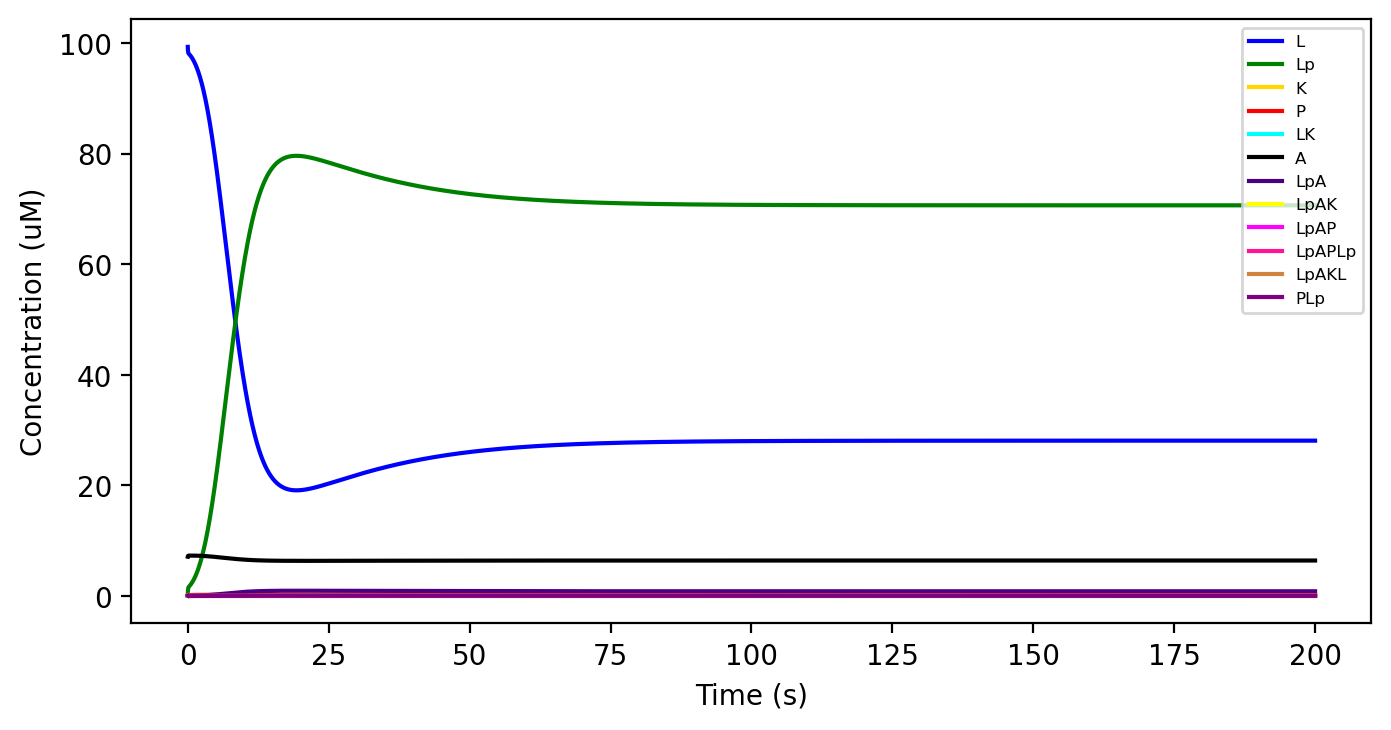

2
{'ka1': 0.14312793707462498, 'kb1': 46.00360623215102, 'kcat1': 306.4036888729987, 'ka2': 0.8067764358831484, 'kb2': 320.40021582253576, 'ka3': 24.71366186997172, 'kb3': 237.82820366555555, 'ka4': 0.022944015876142584, 'kb4': 1.0294411459492174, 'ka7': 0.628310050441584, 'kb7': 105.85213670638129, 'kcat7': 88.77325912667814, 'V': 0.1, 'VA': 1.5, 'sigma': 0.006964042095587593, 'L': 99.36249257706113, 'Lp': 0.09406981196575925, 'K': 0.04839278344484778, 'P': 0.09220505828617995, 'LK': 0.02036446814767011, 'A': 10, 'LpA': 0.08446123333610368, 'LpAK': 0.0415361083838678, 'LpAP': 0.024368964071790122, 'LpAPLp': 0.01880831358051884, 'LpAKL': 0.013852032218669402, 'LpP': 0.0391576806136153}
ka4 > ka1 > ka5 > ka2 > ka3 > 
kb4 > kb1 > kb5 > kb3 > kb2 > 
kcat5 > kcat1 > 
Kd3 > Kd4 > Km5 > Kd2 > Km1 > 
NERDSS parameters
['ka1: 0.2376750864739704 nm^3/us', 'kb1: 4.600360623215102e-05 us^-1', 'kcat1: 0.0003064036888729987 us^-1', 'ka2: 1.3397151044223654 nm^3/us', 'kb2: 0.00032040021582253577 us^

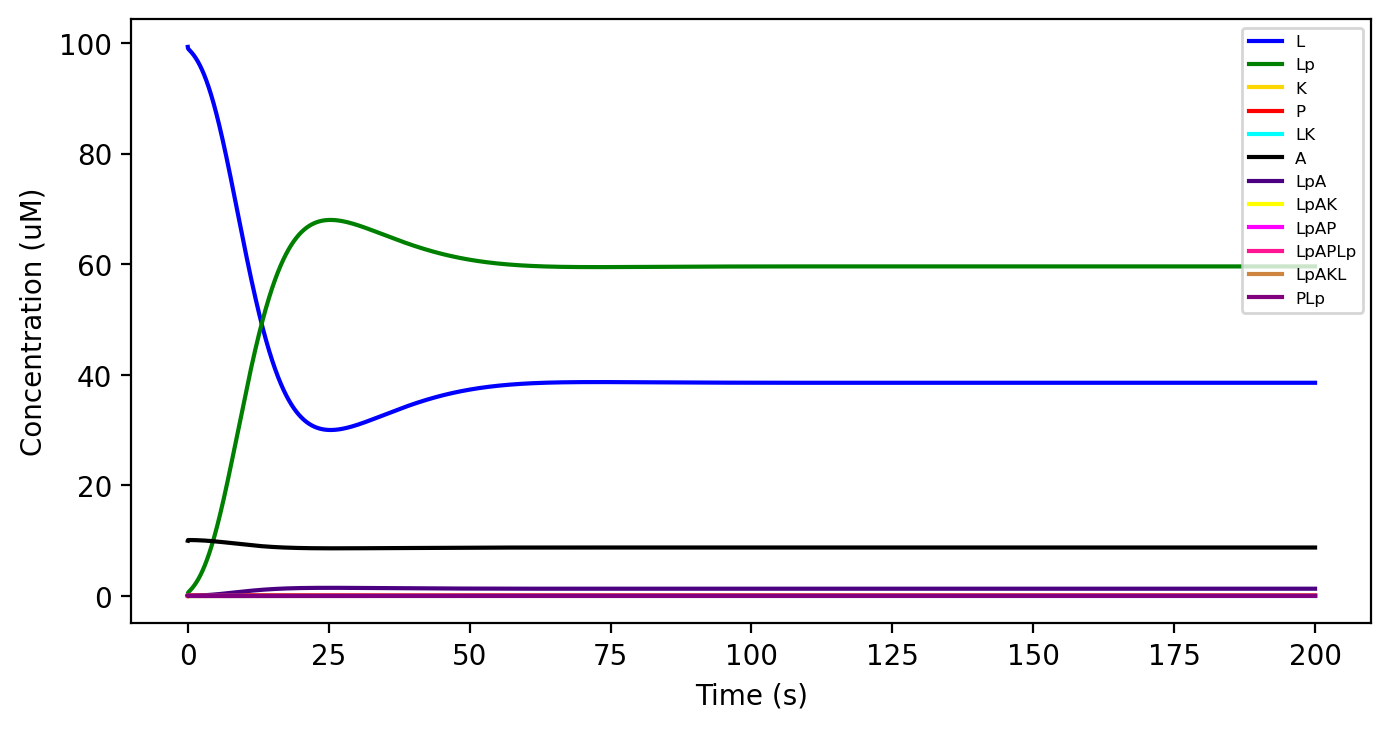

3
{'ka1': 0.08818006548532119, 'kb1': 39.26839204837098, 'kcat1': 306.4036888729987, 'ka2': 0.8746005819400009, 'kb2': 190.3905534372389, 'ka3': 21.255580417659395, 'kb3': 300.15884432174795, 'ka4': 0.022944015876142584, 'kb4': 1, 'ka7': 0.5884645231137812, 'kb7': 105.85213670638129, 'kcat7': 55.99567544184528, 'V': 0.1, 'VA': 1.0963225126615272, 'sigma': 0.006964042095587593, 'L': 99.36249257706113, 'Lp': 0.07209746465233036, 'K': 0.09874123787635496, 'P': 0.09220505828617995, 'LK': 0.022523250440193883, 'A': 10, 'LpA': 0.058552912902921736, 'LpAK': 0.06352402795681639, 'LpAP': 0.03451914136457572, 'LpAPLp': 0.013248832610249592, 'LpAKL': 0.018036307049834437, 'LpP': 0.030816135388909986}
ka4 > ka1 > ka5 > ka2 > ka3 > 
kb4 > kb1 > kb5 > kb2 > kb3 > 
kcat5 > kcat1 > 
Kd3 > Kd4 > Kd2 > Km5 > Km1 > 
NERDSS parameters
['ka1: 0.14642986629910526 nm^3/us', 'kb1: 3.926839204837098e-05 us^-1', 'kcat1: 0.0003064036888729987 us^-1', 'ka2: 1.4523423811690483 nm^3/us', 'kb2: 0.0001903905534372389

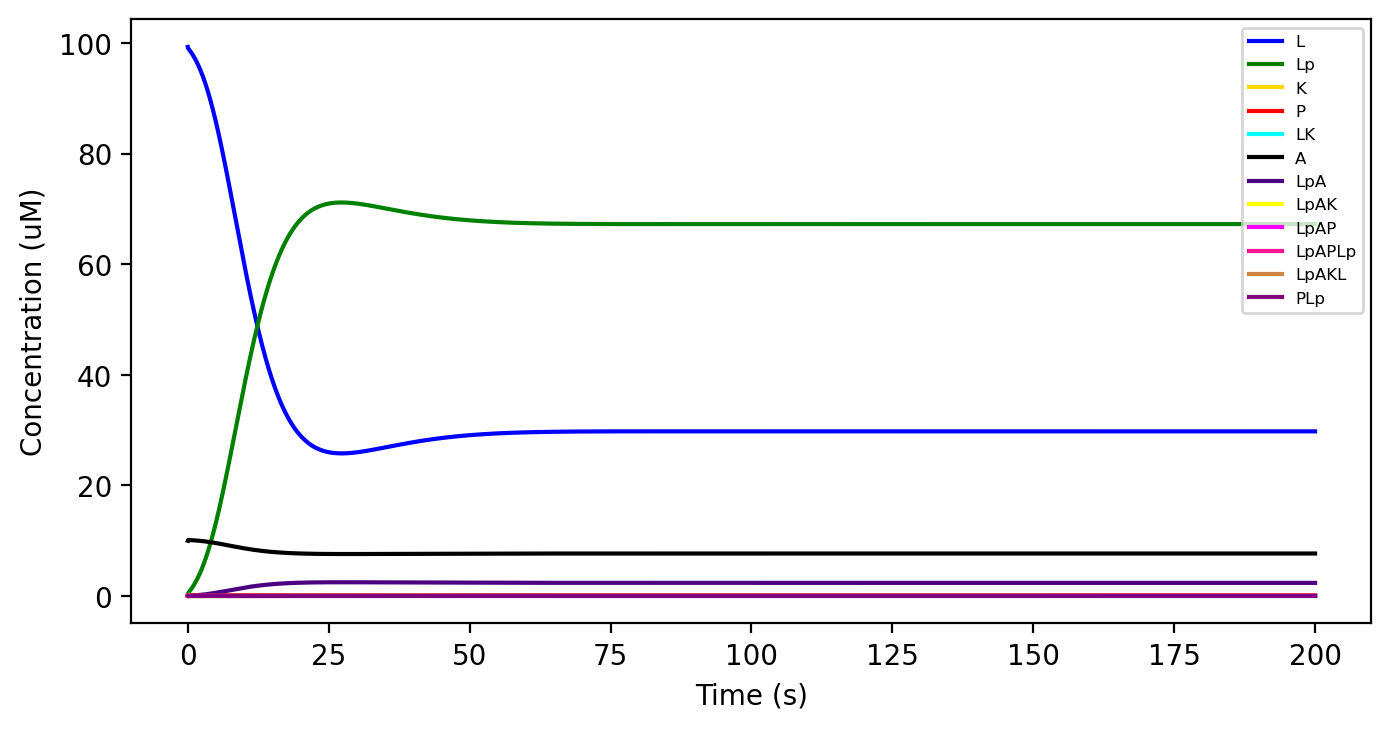

4
{'ka1': 0.11642894286875179, 'kb1': 46.00360623215102, 'kcat1': 337.53569537909164, 'ka2': 0.622745576160182, 'kb2': 88.22994353646126, 'ka3': 9.406156048235356, 'kb3': 174.06215612783618, 'ka4': 0.022944015876142584, 'kb4': 1.0294411459492174, 'ka7': 0.628310050441584, 'kb7': 105.85213670638129, 'kcat7': 54.0911596664823, 'V': 0.09876895387802286, 'VA': 1.3597757072789736, 'sigma': 0.006964042095587593, 'L': 100.0, 'Lp': 0.05542757765719414, 'K': 0.036241945798930635, 'P': 0.04209085889391384, 'LK': 0.012799690948839619, 'A': 10, 'LpA': 0.08446123333610368, 'LpAK': 0.0451324166316467, 'LpAP': 0.023937741293317178, 'LpAPLp': 0.020732835754679584, 'LpAKL': 0.01, 'LpP': 0.0391576806136153}
ka4 > ka1 > ka2 > ka5 > ka3 > 
kb4 > kb1 > kb2 > kb5 > kb3 > 
kcat5 > kcat1 > 
Kd3 > Kd4 > Kd2 > Km5 > Km1 > 
NERDSS parameters
['ka1: 0.19333932724801028 nm^3/us', 'kb1: 4.600360623215102e-05 us^-1', 'kcat1: 0.00033753569537909163 us^-1', 'ka2: 1.0341175293261076 nm^3/us', 'kb2: 8.822994353646127e-0

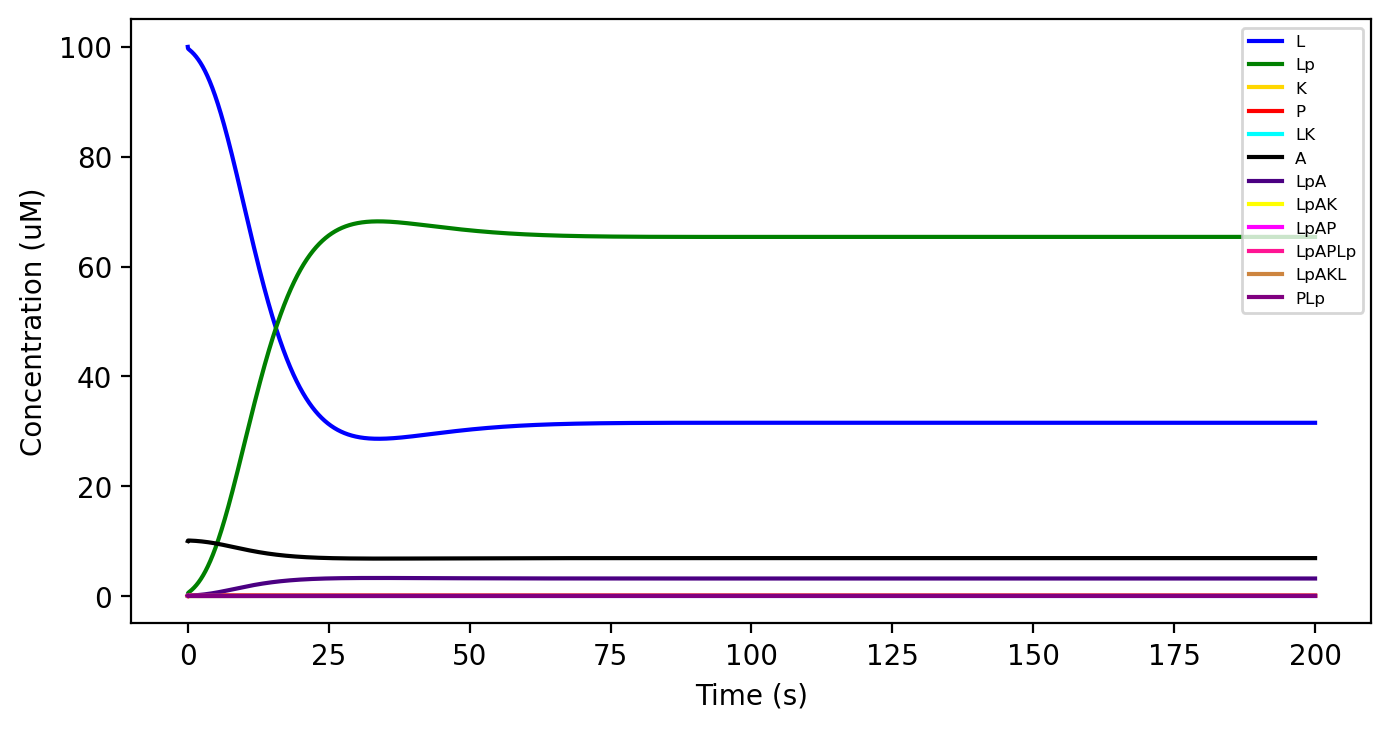

5
{'ka1': 0.1790329436710993, 'kb1': 30.594038670016943, 'kcat1': 244.34204370296487, 'ka2': 0.9102360940716324, 'kb2': 189.3460740307026, 'ka3': 7.581763391599415, 'kb3': 290.20286607054345, 'ka4': 0.022944015876142584, 'kb4': 1, 'ka7': 1.0, 'kb7': 136.8113424580411, 'kcat7': 103.01878269812343, 'V': 0.1, 'VA': 1.0963225126615272, 'sigma': 0.002074811561678751, 'L': 100.0, 'Lp': 0.05542757765719414, 'K': 0.036241945798930635, 'P': 0.028710235403180573, 'LK': 0.02089947001381471, 'A': 10, 'LpA': 0.0736482948609359, 'LpAK': 0.019127804239908293, 'LpAP': 0.07864670583668275, 'LpAPLp': 0.027644405537523543, 'LpAKL': 0.02314731940196678, 'LpP': 0.05279790951707145}
ka4 > ka1 > ka2 > ka5 > ka3 > 
kb4 > kb1 > kb5 > kb2 > kb3 > 
kcat5 > kcat1 > 
Kd3 > Kd4 > Kd2 > Km5 > Km1 > 
NERDSS parameters
['ka1: 0.2972981462489195 nm^3/us', 'kb1: 3.059403867001694e-05 us^-1', 'kcat1: 0.0002443420437029649 us^-1', 'ka2: 1.5115179243965997 nm^3/us', 'kb2: 0.0001893460740307026 us^-1', 'ka3: 12.590108587843

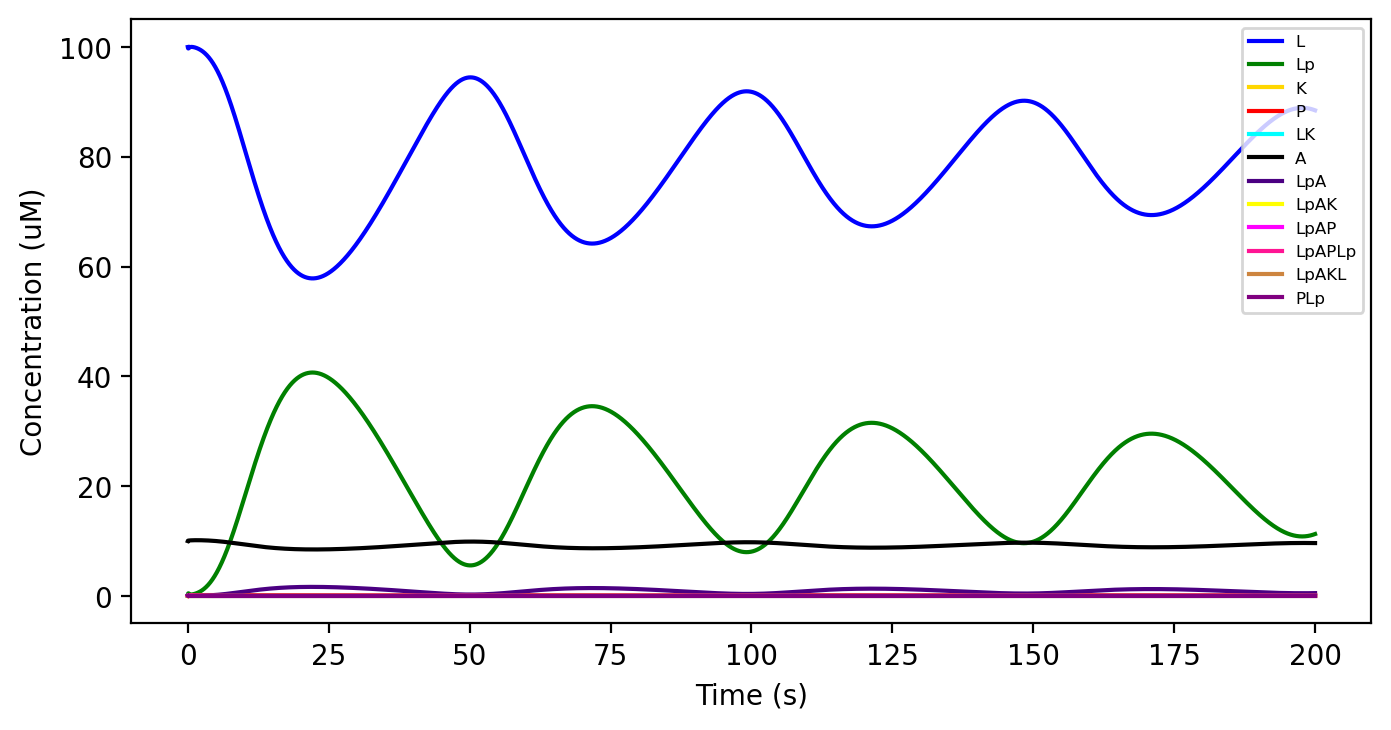

6
{'ka1': 0.14581031790396115, 'kb1': 63.21357861717505, 'kcat1': 306.4036888729987, 'ka2': 1.0, 'kb2': 119.91157790359144, 'ka3': 12.451292430036824, 'kb3': 325.8291744040927, 'ka4': 0.022944015876142584, 'kb4': 1.080438654029758, 'ka7': 1.0, 'kb7': 53.51329113427846, 'kcat7': 88.77325912667814, 'V': 0.1, 'VA': 1.103568444347901, 'sigma': 0.001910177792252444, 'L': 100.0, 'Lp': 0.07963395299401856, 'K': 0.036241945798930635, 'P': 0.028710235403180573, 'LK': 0.015625632212062333, 'A': 10, 'LpA': 0.06714147031794833, 'LpAK': 0.019127804239908293, 'LpAP': 0.1, 'LpAPLp': 0.016030710413972242, 'LpAKL': 0.018194776763387495, 'LpP': 0.05097559805679991}
ka4 > ka1 > ka2 > ka5 > ka3 > 
kb4 > kb5 > kb1 > kb2 > kb3 > 
kcat5 > kcat1 > 
Kd3 > Kd4 > Kd2 > Km5 > Km1 > 
NERDSS parameters
['ka1: 0.24212938874785978 nm^3/us', 'kb1: 6.321357861717505e-05 us^-1', 'kcat1: 0.0003064036888729987 us^-1', 'ka2: 1.6605778811026237 nm^3/us', 'kb2: 0.00011991157790359143 us^-1', 'ka3: 20.676340800459688 nm^3/us'

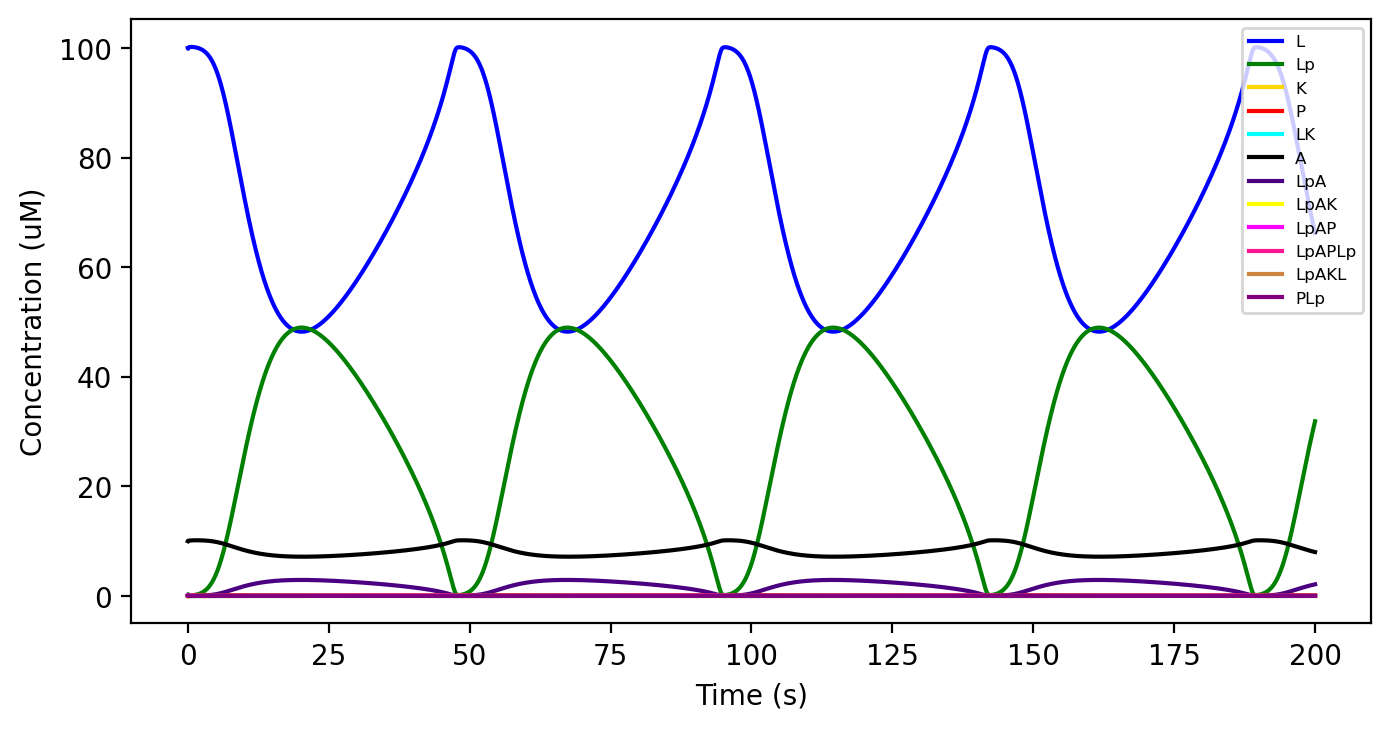

7


KeyboardInterrupt: 

In [84]:
parameter_values = {  "ka1": {"min": 1000/1e6, "max": 1e6/1e6},  
            "kb1": {"min": 1, "max": 100},             				        
            "kcat1": {"min": 1, "max": 500},         
            "ka2": {"min": 1000/1e6, "max": 1e6/1e6},         
            "kb2": {"min": 1, "max": 1000}, 
            "ka3": {"min": 1e3/1e6, "max":1e8/1e6}, 
            "kb3": {"min": 1, "max":500},
            "ka4": {"min": 1e3/1e6, "max":1e6/1e6},
            "kb4": {"min": 1, "max": 100},  
            "ka7": {"min": 1e3/1e6, "max": 1e6/1e6}, 
            "kb7": {"min": 1, "max": 1000}, 
            "kcat7": {"min": 1, "max": 200},
            "V": {"min": 0.05, "max": 0.1},
            "VA": {"min": 0.5, "max": 1.5},
            "sigma": {"min": 0.001, "max": 0.01},
            "L": {"min": 1, "max": 1e2},  
            "Lp": {"min": 0.01, "max": 0.1}, 
            "K": {"min": 0.01, "max": 0.1},
            "P": {"min": 0.01, "max": 0.1},
            "LK": {"min": 0.01, "max": 0.1}, 
            "A": {"min": .1, "max": 10}, 
            "LpA": {"min": 0.01, "max": 0.1},
            "LpAK": {"min": 0.01, "max": 0.1}, 
            "LpAP": {"min": 0.01, "max": 0.1}, 	
            "LpAPLp": {"min": 0.01, "max": 0.1},
            "LpAKL": {"min": 0.01, "max": 0.1},
            "LpP": {"min": 0.01, "max": 0.1},
            }      	

filename =  os.path.join(".", "SIMPLE2_oscillatorCostTwo")  
print(filename)   
model = Oscillator(parameter_values, np.array(["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka7","kb7","kcat7","V","VA","sigma","L","Lp","K","P","LK","A","LpA","LpAK","LpAP","LpAPLp","LpAKL","LpP"]), np.array(["L","Lp","K","P",0,"A",0,0,0,0,0,0]), mode=1)  
solver = Solver(model)         
solver.run(filename) 

In [ ]:
## rewrite ODE's with gamma
## have V/A be evolvable parameter
## figure out units for time and concentration
## extract relative rates from GA (ka1 > ka2)
## change units to uM for smaller numbers

## see if integration time is affecting the period that is being optimized for 

## is the cost function getting messed up by different initial conditions?
## test peakutils.indexes

##try adding LpP reaction and see if it still works

##linear stability analysis

In [ ]:
#[0.10959866882379117, 100, 500, 1.0, 14.509185071752723, 25.678846819773778, 439.78604024304275, 0.1095887494500306, 0.8808212958162254, 0.8585736242433817, 
#29.956442931043107, 158.5028005257002, 2600, 2, 0.001, 68.29345291176342, 0.0, 0.03904729515056038, 0.1, 0.0, 9.567624561670941, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

## Calculate waterbox function

In [42]:
def waterbox(V,VA):
    V = V * 1e9 #convert um3 to nm3
    VA = VA * 1000 #convert um to nm 

    A = V/VA #units of nm2
    x = np.sqrt(A)
    y = np.sqrt(A)
    z = V/A 

    #ztest = z/10
    #xtest = np.sqrt(V/ztest)
    #ytest = np.sqrt(V/ztest)

    #test = (ztest*xtest*ytest)/(xtest*ytest)

    return x, y, z



In [43]:
waterbox(0.05,1.6)

(176.7766952966369, 176.7766952966369, 1600.0)

In [37]:
waterbox(2600,1.6)

(40311.288741492746, 40311.288741492746, 1600.0000000000002, 1600.0)

## Calculate copy numbers function

In [46]:
def copynumber(conc, volume, um = True):
    if um == True:
        volume = volume/1e15
        conc = conc/1e6
        
        moles = conc * volume
        copies = moles * 6.023e23
        
        return copies
    elif um == False:
        volume = volume/1e15
        moles = conc / volume
        rate = moles / 6.023e23

        return rate

In [81]:
copynumber(92.6979968169064, 0.05965435429102459)

3330.622116542026

## Calculate rate constants function

In [47]:
#function to convert molar to nm^-3, or vice versa, and copy numbers 

def rate_converter(rate, ka = True):
    #convert ka in (uM*s)^-1 to nm^3/us
    if ka == True:
        new_rate = rate/1e6 #seconds to microseconds
        new_rate = new_rate * 1e24 #convert liters to nm^3
        new_rate = new_rate/(6.022*1e17) #convert micromoles to copies 
        return new_rate
    else: #else kb or kcat in s^-1
        new_rate = rate / 1e6 #convert per second to per microsecond
        return new_rate 

In [58]:
rate_converter(0.07495786915988335, ka = False)

7.495786915988335e-08

# Analysis

In [7]:
plt.rcParams.update({'font.size': 12}) 

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Candidate", list, fitness=creator.FitnessMax)		
toolbox = base.Toolbox()	 
toolbox.register("candidate", Solver.generateCandidate) 
				
     
folder1 = os.path.join(".", "SIMPLE2_oscillatorCostTwoViableSet_IterGA.p")      				
				
file1 =  folder1      
           

viablePoints2 = pickle.load(open(file1, "rb"))  
   

allViablePoints = viablePoints2
pca = PCA(n_components=2)
pca.fit(allViablePoints)

model2 = Oscillator(parameter_values, np.array(["ka1", "kb1", "kcat1", "ka2", "kb2", "ka3", "kb3", "ka4","kb4","ka5","kb5","kcat5"]), np.array([500,0,50,50,0,50,0,0,0,0,0]), mode=1) 

###                   ###
###  SSA simulations  ###
###                   ###  

#sample few random points from viable regions for region 2     
readFromFile = False                 

region2 = viablePoints2    
numSamples = 9
if readFromFile:
	sampleNumbers2 = pickle.load(open("stochastic_samples_numbers_repressilator", "rb"))
else:
	num2 = region2.shape[0]  
	sampleNumbers2 = np.random.choice(num2, numSamples, replace=False)   
	pickle.dump(sampleNumbers2, open("stochastic_samples_numbers_repressilator", "wb+"))    
	
#plot few simulations (ode + ssa)
t = np.linspace(0, model2.T, model2.N)
#t = np.linspace(0, 1000, model2.N)
if readFromFile:
	samples = pickle.load(open("stochastic_samples_repressilator","rb"))     
else:	
	samples = region2[sampleNumbers2,:]
	pickle.dump(samples, open("stochastic_samples_repressilator", "wb+"))   
	
notWorking = samples[numSamples-3:numSamples,:] 
notWorking = np.copy(notWorking) 
notWorking[0,2] = 1 #low hill coefficient
notWorking[1,0] = 1 #low transcription 
notWorking[2,5] = 10 #high protein degradation   

allSamples = np.vstack((samples, notWorking)) 

ts_total_stochastic = [] 
Y_total_stochastic = []
t_total_ode = []
Y_total_ode = []



if readFromFile:
	t_total_ode, Y_total_ode = pickle.load(open("stochastic_simulations_repressilator", "rb"))  

plt.figure(figsize=(25,25))
for i in range(numSamples + 3): 
	print(i)  
	
	ax1=plt.subplot(4, 3, i + 1)

	ax1.set_title("Sample " + str(i + 1), fontsize=12)	 
	
	sample = allSamples[i] 
	if readFromFile:
		#ts = ts_total_stochastic[i]   
		#Y = Y_total_stochastic[i]  
		Y_ode = Y_total_ode[i]  
		t = t_total_ode[i]  
	else:
		#ts, Y = model2.represilatorStochastic(sample)
		#Y = Y/model2.omega 
		Y_ode = model2.simulate(sample)  
		#ts_total_stochastic.append(ts)
		#Y_total_stochastic.append(Y) 
		t_total_ode.append(t)  
		Y_total_ode.append(Y_ode) 
	

	plt.plot(t, Y_ode[:,0], color="b", label = 'L')
	plt.plot(t,Y_ode[:,1], color="r", label = 'Lp')
	plt.plot(t,Y_ode[:,2], color="gold", label = 'K')
	plt.plot(t,Y_ode[:,3], color="g", label = 'P')
	plt.plot(t,Y_ode[:,4], color="cyan", label = 'LK')
	plt.plot(t,Y_ode[:,5], color="black", label = 'A')
	plt.plot(t,Y_ode[:,6], color="indigo", label = 'LpA')
	plt.plot(t,Y_ode[:,7], color="yellow", label = 'LpAK')
	plt.plot(t,Y_ode[:,8], color="magenta", label = 'LpAP')
	plt.plot(t,Y_ode[:,9], color="deeppink", label = 'LpAPLp')
	plt.plot(t,Y_ode[:,10], color="peru", label = 'LpAKL')
	#lines = plt.plot(t, Y_ode[:,0], t, Y_ode[:,1], t, Y_ode[:,2], t, Y_ode[:,3], t, Y_ode[:,4], t, Y_ode[:,5], t, Y_ode[:,6], t, Y_ode[:,7], t, Y_ode[:,8]) #ts, Y[:,1])  
	#plt.setp(lines[0], linestyle = "-", linewidth=1.5, alpha=1, c="#15A357")
	


		
	if i == 9 or i == 10 or i == 11:
		plt.xlabel(r"Time [$h$]")    
	if i == 0 or i == 3 or i == 6 or i == 9:
		plt.ylabel('Concentration [$nM$]') 
	if i == 2:
		plt.legend(loc = 1) 
plt.savefig("time_series.png")  	
plt.show()


if not readFromFile:
	pickle.dump((t_total_ode, Y_total_ode) ,open("stochastic_simulations_repressilator", "wb+"))       	
	
#plot boxplots
repetitions = 100    
amps = []
pers = []      
ode_amps = []
ode_pers = []

if readFromFile:
	pers, amps = pickle.load(open("stochastic_persamps_repressilator","rb")) 
for i in range(numSamples): 
	print(i) 
	sample = samples[i]
	per, amp = model2.getPerAmp(sample, mode="ode", indx=1)   
	ode_amps.append(amp)   
	ode_pers.append(per)    
	
	#if not readFromFile:	
		#curra = []
		#currp = []
		#for j in range(repetitions):
			#per, amp = model2.getPerAmp(sample, mode="ssa", indx=1)  
			#amp = amp/model2.omega    
			#curra.append(amp)  
			#currp.append(per)   		
		#amps.append(curra) 
		#pers.append(currp) 

if not readFromFile:	
	pickle.dump((pers, amps), open("stochastic_persamps_repressilator", "wb+"))  



AttributeError: 'list' object has no attribute 'shape'

In [61]:
'kb' in 'L' or 'kcat' in 'L'

False

In [6]:
0.000135*1e6

135.0